# Machine Learning Engineer Nanodegree
## Investment and Trading Capstone Project
## Project: Build a Stock Price Indicator
----
The stucture of this Notebook is inherited from the [Udacity project template: Finding Donors for CharityML](https://github.com/udacity/machine-learning/blob/master/projects/finding_donors/finding_donors.ipynb).
### Load common Libraries, Constants and Functions.

In [1]:
import numpy                as     np
import pandas               as     pd
import seaborn              as     sns
import matplotlib.pyplot    as     plt
import matplotlib.dates     as     dates
from   datetime             import date, timedelta
from   time                 import time
from   IPython.display      import display         # Allows the use of display() for DataFrames
from   collections          import OrderedDict

# Pretty display for notebooks
%matplotlib inline

# display_En   = True # Enable/Disable unnecessary complex figures to speed up the data flow

In [2]:
random_state =  7
data_p       = '7Y'                # Years, data_period to get data from current date
Page_size    = 17                  # inch, for figure size
date_split   = date(2018,   1,  1) # Split train/test data by the date
day          = timedelta(days = 1)
class_name   = lambda c: c.__class__.__name__
percent      = '{:6.2f}%'
R            = '#dd4b39'           # Google Red
G            = '#3cba54'           # Google Green
B            = '#4885ed'           # Google Blue
Y            = '#f4c20d'           # Google Yellow

def     concat        (df,      keys = None): return pd.concat( df, axis = 1, keys = keys)
def     concat_idx    (df, idx, keys = None): return    concat([df[i] for i in idx], keys)
def     concat_display(df, idx, keys = None , n = 5, head = False):
    d = concat_idx    (df, idx, keys = keys)
    display(d.head(n = n) if head else d.tail(n = n))
    return  d

## Data Exploration
Load necessary Python libraries and the price data.
The datasets used in this project is obtained by the python module [googlefinance.client](http://pypi.python.org/pypi/googlefinance.client) instead of the planned popular [yahoo-finance](http://pypi.python.org/pypi/yahoo-finance) [which is being discontinued](http://yahoo.sdx.socialdynamx.com/portal/conversation/19248672).
### Raw Data Getting
Import 7-year data of the [S&P 500 Index](http://wikipedia.org/wiki/S%26P_500_Index), till the showed current day below.
The columns of this dataset will be calculated to our target labels (the next day price ups, flats or downs) for each day.
The column or index names from the two functions are needs to be cleaned respectively.

In [3]:
try:
    from   googlefinance.client import get_price_data, get_prices_data #, get_prices_time_data
    
    # Load daily prices of the S&P 500
    data = get_price_data({
       'x': 'INDEXSP', # Stock exchange symbol (S&P 500: 'INDEXSP', Dow Jones: 'INDEXDJX', NYSE COMPOSITE: 'INDEXNYSEGIS'  )
       'q': '.INX'   , # Stock symbol          (S&P 500: '.INX'   , Dow Jones: '.DJI'    , NYSE COMPOSITE: 'NYA', 'AAPL'...)
       'i': '86400'  , # Interval seconds      ('86400' = 1 day  intervals)
       'p': data_p     # Period                (   '1Y' = 1 year period   )
    })                 # get price data        (return pandas dataframe)
    # Success - Display the first record
    display(data.tail(n = 1))
    
    # Comparing to get_price_data, get_prices_data focuses on daily data (avoid confusion although the same data) and flexibility
    data = get_prices_data([{
       'x': 'INDEXSP', # Stock exchange symbol (S&P 500: 'INDEXSP', Dow Jones: 'INDEXDJX', NYSE COMPOSITE: 'INDEXNYSEGIS'  )
       'q': '.INX'   , # Stock symbol          (S&P 500: '.INX'   , Dow Jones: '.DJI'    , NYSE COMPOSITE: 'NYA', 'AAPL'...)
    }],     data_p   ) # get price data        (return pandas dataframe)
    # Success - Display the first record
    display(data.tail(n = 1))
    
    data     .  to_csv  ('SP.csv.txt')                                    # Save the got data (10 years: 125 KB)
except:                                                                   # Load saved data if googlefinance is not available
    data = pd.read_csv  ('SP.csv.txt', index_col = 0, parse_dates = True) # Load the got data (when googlefinance fails)

,Open,High,Low,Close,Volume
2018-04-14 04:00:00,2676.9,2680.26,2645.05,2656.3,1823268887


,.INX_Open,.INX_High,.INX_Low,.INX_Close,.INX_Volume
2018-04-14,2676.9,2680.26,2645.05,2656.3,1823268887


### Data Cleaning
The column names are cleaned and the data with abnormal 0 also need to be checked.

In [4]:
data  = data.rename(columns = lambda c: c.split('_')[-1]) # Clean column names
display(data.describe())                                  # Check data

,Open,High,Low,Close,Volume
count,1758.000000,1758.000000,1758.000000,1758.000000,1.758000e+03
mean,1888.268447,1897.022048,1878.961286,1890.123606,8.664867e+08
std,423.076945,423.256591,422.745545,420.764268,6.579130e+08
min,0.000000,0.000000,0.000000,1099.230000,0.000000e+00
25%,1472.172500,1474.097500,1467.585000,1474.707500,4.949631e+08
50%,1957.030000,1964.890000,1944.665000,1957.100000,5.859083e+08
75%,2127.730000,2133.192500,2119.982500,2127.612500,8.574282e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


Check the 0 `Volume`. The early years lack `Volume` data need to be cleaned.

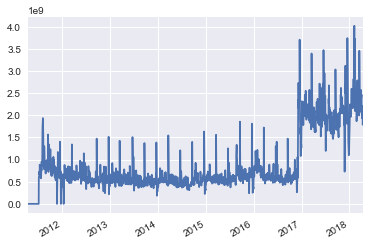

In [5]:
data['Volume'].plot();                                    # Check the 0 Volume

The cleaned data with complete `Volume` start from 2012-01-15.
However, there are still 0 prices need to be checked.

In [6]:
# Drop days with 0 Volumn & check again
Day_Volume  = data[data['Volume'] == 0].index[-1] + day
print 'Cleaned data with Volume start from: ' + str(Day_Volume)
data_Volume = data[Day_Volume:]
display(data_Volume.describe())

Cleaned data with Volume start from: 2012-01-15


,Open,High,Low,Close,Volume
count,1570.000000,1570.000000,1570.000000,1570.000000,1.570000e+03
mean,1964.248643,1972.791828,1955.200936,1966.349306,9.024984e+08
std,381.970861,382.676000,381.003823,378.646804,6.698662e+08
min,0.000000,0.000000,0.000000,1278.040000,1.839316e+08
25%,1674.555000,1681.075000,1662.882500,1676.155000,4.983000e+08
50%,2003.615000,2017.540000,1992.490000,2002.470000,5.796182e+08
75%,2165.512500,2171.070000,2156.945000,2164.630000,8.682517e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


Check the data distributions.
The normal prices are over 1000.

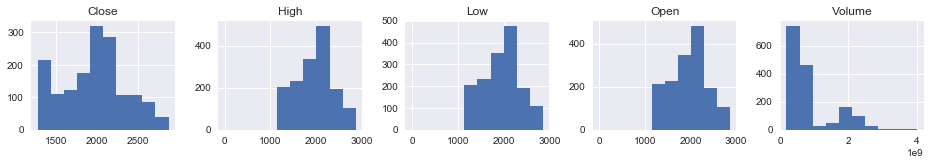

In [7]:
data_Volume.hist(figsize = (16, 2), layout = (1, 5));     # Check the data distributions

There is only one abnormal day needs to be dropped

In [8]:
for c in ['Open', 'High', 'Low']:
    display(data_Volume[data_Volume[ c    ] < 1000]) # Check prices < 1000 (the strange gap in 'Open', 'High', and 'Low')

,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


The data statistics and distributions are clean.
The `Volume` values need Log-transform.

,Open,High,Low,Close,Volume
count,1569.000000,1569.000000,1569.000000,1569.000000,1.569000e+03
mean,1965.500554,1974.049184,1956.447081,1966.028113,9.016781e+08
std,378.856947,379.540049,377.911261,378.553520,6.692904e+08
min,1277.820000,1282.550000,1266.740000,1278.040000,1.839316e+08
25%,1675.260000,1683.730000,1663.520000,1676.120000,4.982664e+08
50%,2003.660000,2018.190000,1992.540000,2002.330000,5.795952e+08
75%,2165.640000,2171.360000,2157.090000,2164.450000,8.658505e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


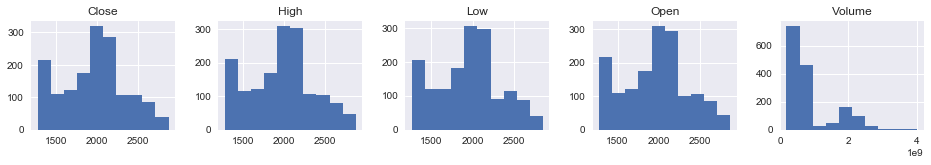

In [9]:
data_Volume_Price     = data_Volume[
                        data_Volume['Open'] > 1000]               # Drop the abnormal day
data_Volume_Price     . hist(figsize = (16, 2), layout = (1, 5));
display               ( data_Volume_Price.describe())
data_cln              = data_Volume_Price                         # Cleaned data

### Feature Exploration and Derivation
Besides the base prices and `Volume` features, more price changing vectors, corresponding classes and statistics are derived for the proposed target and further improvement, e.g.,
`Close_pre_Close` vector: the price changes from Close of the last **pre**vious day to Close of the base day & `Close_Close_next_up` classification: the price **up**s from Close of the base day to Close of the **next** day.
Although the feature `Open_next` will limit the available time, the closest price is supposed to have the highest correlation with the target `Close_Close_next_up`.
The flatting prices are merged with upping prices, aligned with the [matplotlib.finance](http://matplotlib.org/api/finance_api.html)
The statistics are calculated by the [stockstats](http://pypi.python.org/pypi/stockstats).

In [10]:
col_pre   =  ['Open' ,   'Close']                  # Collect previous daily data column to cancat together
col_next  =  ['Open' ,   'Close']                  # Collect next     daily data column to cancat together
d         = concat([   data_cln[     col_pre ].shift( 1).rename(columns = lambda c: c + '_pre' ),
                       data_cln])                  # d is the acronyms to cancat all data
d         = concat([d, data_cln[     col_next].shift(-1).rename(columns = lambda c: c + '_next')
                               ])[1:-1]            # Drop the 1st/last one which lacks a previous/next daily data
y_rgr     = list  ( d. columns [-len(col_next):])  # Select data column for regression y

X_vec, y_clf_vec = [], []
for                    p1,     p2 in [
   # Timeline: Open_pre > Close_pre > Open >  Close >  Open_next >  Close_next
             ('Open_pre'                   , 'Close'                           ), # Vector from Open_pre  to Close
             (           'Close_pre'       , 'Close'                           ), # Vector from Close_pre to Close
             (                       'Open', 'Close'                           ), # Vector from Open      to Close
             (                       'Open',          'Open_next'              ), # Vector from Open      to  Open_next
             (                               'Close', 'Open_next'              ), # Vector from Close     to  Open_next
             (                               'Close',              'Close_next'), # Vector from Close     to Close_next
             (                                        'Open_next', 'Close_next'), # Vector from Open_next to Close_next
             ]:
    p      = '_'.join([p1,     p2    ])
    d [p]  =  -      d[p1] + d[p2]
    if 0  <=    p.find  ('Close_next' ): # next daily data are usually for y
        y_clf_vec.append(      p      )  # Vectors for classification y
    else:
        X_vec    .append(      p      )

X_up, y_clf = [], []
for vec      in     X_vec + y_clf_vec  : # Index of records where the next daily prices up
    col    =          vec +     '_up'    # Merge 'flat' to 'up': Align to the 'up' of matplotlib.finance
    d[col] =  0 <=  d[vec]
    if 0  <=  col.find  ('Close_next' ): # next daily data are usually for y
        y_clf    .append(        col  )
    else:
        X_up     .append(        col  )

X_base     = list(data_cln.columns)
X_all      = X_base + X_vec + X_up     # Select data column for X
# Xy     = [c for c in d.columns if 0 <= c.find('Open_next') and c.find('Close_next') < 0  ] # X sometimes includes Open_next

Close_Close_next_flat =         0   == d.    Close_Close_next
Close_Open_next_flat  =         0   == d.     Close_Open_next

n_records             = d.shape[0]                                # Total number of records
n_up                  = sum    (       d.Close_Close_next_up    )
n_flat                = sum    (         Close_Close_next_flat  )
n_down                = sum    (0    > d.Close_Close_next       )
up_percent            = float  (n_up)/n_records*100               # Percentage of days whose price up

print '[Statistics of Close-to-Close (Close_Close_next) prices]'
print 'Total number of records: {}'               .format(n_records )
print 'Daily prices upping:     {}  ({})'         .format(n_up      , 'Close_Close_next_up, including flatting aligned w/ matplotlib.finance')
print 'Daily prices flatting:   {}'               .format(n_flat    )
print 'Daily prices downing:    {}'               .format(n_down    )
print 'Percentage of daily prices upping: {:.2f}%'.format(up_percent)

print '\nThe flat days with the same Close prices'
display       ( d[Close_Close_next_flat | Close_Close_next_flat.shift(1)])
print '\nThe flat day  with the same Open & Close prices'
display       ( d[    d.Open           ==  d.Close                      ])
# print '\n     {} days with the same Close & Open_next prices'.format(sum(Close_Open_next_flat))
# display       ( d[ Close_Open_next_flat |  Close_Open_next_flat.shift(1)].head(n = 2))

[Statistics of Close-to-Close (Close_Close_next) prices]
Total number of records: 1567
Daily prices upping:     847  (Close_Close_next_up, including flatting aligned w/ matplotlib.finance)
Daily prices flatting:   1
Daily prices downing:    720
Percentage of daily prices upping: 54.05%

The flat days with the same Close prices


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Close_Open_next,Close_Close_next,Open_next_Close_next,Open_pre_Close_up,Close_pre_Close_up,Open_Close_up,Open_Open_next_up,Close_Open_next_up,Close_Close_next_up,Open_next_Close_next_up
2017-01-10,2271.14,2276.98,2273.59,2275.49,2268.90,2268.9,1914652521,2269.72,2268.90,-2.24,...,0.82,0.00,-0.82,False,False,False,False,True,True,False
2017-01-11,2273.59,2268.90,2269.72,2279.27,2265.27,2268.9,2138024556,2268.60,2275.32,-4.69,...,-0.30,6.42,6.72,False,True,False,False,False,True,True



The flat day  with the same Open & Close prices


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Close_Open_next,Close_Close_next,Open_next_Close_next,Open_pre_Close_up,Close_pre_Close_up,Open_Close_up,Open_Open_next_up,Close_Open_next_up,Close_Close_next_up,Open_next_Close_next_up
2017-04-11,2356.59,2355.54,2357.16,2366.37,2351.5,2357.16,1620328913,2353.92,2353.78,0.57,...,-3.24,-3.38,-0.14,True,True,True,False,False,False,False


#### Featureset Exploration
The applied price-change Vectors are listed below and there are also corresponding up/down classes:

<table border = "1">
    <tr>
      <th style = "text-align: left"              >                   </th>
      <th style = "text-align: left" colspan = "6"> Timeline ===>     </th>
    </tr>
    <tr>
      <th style = "text-align: left"              >             3 Days</th>
      <th style = "text-align: left" colspan = "2"> Last previous Day </th>
      <th style = "text-align: left" colspan = "2">      Base     Day </th>
      <th style = "text-align: left" colspan = "2">      next     Day </th>
    </tr>
    <tr>
      <th style = "text-align: left"              > Prices            </th>
      <th style = "text-align: left"              > Open_pre          </th>
      <th style = "text-align: left"              > Close_pre         </th>
      <th style = "text-align: left"              > Open              </th>
      <th style = "text-align: left"              > Close             </th>
      <th style = "text-align: left"              > Open_next         </th>
      <th style = "text-align: left"              > Close_next        </th>
    </tr>
    <tr>
      <th style = "text-align: left"              >                   </th>
      <th style = "text-align: left" colspan = "5"> X (Features)      </th>
      <th style = "text-align: left"              > y (Label)         </th>
    </tr>
    <tr>
      <th style = "text-align: left" rowspan = "5"> Feature Vectors   </th>
      <th style = "text-align: left" colspan = "4">  Open_pre_Close   </th>
    </tr>
    <tr>
      <th style = "text-align: left"              >                   </th>
      <th style = "text-align: left" colspan = "3"> Close_pre_Close   </th>
    </tr>
    <tr>
      <th style = "text-align: left" colspan = "2">                   </th>
      <th style = "text-align: left" colspan = "2">  Open_Close       </th>
    </tr>
    <tr>
      <th style = "text-align: left" colspan = "2">                   </th>
      <th style = "text-align: left" colspan = "3">  Open_Open_next   </th>
    </tr>
    <tr>
      <th style = "text-align: left" colspan = "3">                   </th>
      <th style = "text-align: left" colspan = "2"> Close_Open_next   </th>
    </tr>
    <tr>
      <th style = "text-align: left" rowspan = "2">  Target Vectors   </th>
      <th style = "text-align: left" colspan = "3">                   </th>
      <th style = "text-align: left" colspan = "3"> Close_Close_next  </th>
    </tr>
    <tr>
      <th style = "text-align: left" colspan = "4">                   </th>
      <th style = "text-align: left" colspan = "2">  Open_Close_next  </th>
    </tr>
</table>
Here are the current data, the more `y` are for further discussion:

In [11]:
hdr_base =       'Base Features ~  X_base' # Headers
hdr_vec  =     'Vector Features ~  X_vec'  #
hdr_up   =         'Up Features ~  X_up'   #
hdr_stat = 'Statistics Features ~  X_stat' # will add later
X_grp    =                      [  X_base             ,  X_vec,             X_up          ]
def X_display            (d,       X_grp = X_grp      , head = 0, n = 5):
    return concat_display(d,       X_grp              ,
                                [hdr_base             ,hdr_vec          , hdr_up, hdr_stat][:len(X_grp)], head = head, n = n)
def y_display            (d,       y_clf = y_clf      ,  y_rgr = y_rgr ):
    return concat_display(d,    [  y_clf              ,  y_rgr         ],
                                [ 'y (Classification)', 'y (Regressions)'])

X_display                (d)
y_display                (d);
# display                  (d[      y_clf_vec         ].rename(columns = lambda c: ('Vectors for Classification', c)).tail())

Base Features ~  X_base                                         \
                              Open     High      Low    Close      Volume   
2018-04-07                 2645.82  2656.88  2586.27  2604.47  2187111865   
2018-04-10                 2617.18  2653.55  2610.79  2613.16  1923050595   
2018-04-11                 2638.41  2665.45  2635.78  2656.87  2132599583   
2018-04-12                 2643.89  2661.43  2639.25  2642.19  1788526146   
2018-04-13                 2653.83  2674.72  2653.83  2663.99  1922966393   

           Vector Features ~  X_vec                                            \
                     Open_pre_Close Close_pre_Close Open_Close Open_Open_next   
2018-04-07                   -52.89          -58.37     -41.35         -28.64   
2018-04-10                   -32.66            8.69      -4.02          21.23   
2018-04-11                    39.69           43.71      18.46           5.48   
2018-04-12                     3.78          -14.68      -1.70           9.94   
2018-04-13                    20.10           21.80      10.16          23.07   

                           Up Features ~  X_up                     \
           Close_Open_next   Open_pre_Close_up Close_pre_Close_up   
2018-04-07           12.71               False              False   
2018-04-10           25.25               False               True   
2018-04-11          -12.98                True               True   
2018-04-12           11.64                True              False   
2018-04-13           12.91                True               True   

                                                               
           Open_Close_up Open_Open_next_up Close_Open_next_up  
2018-04-07         False             False               True  
2018-04-10         False              True               True  
2018-04-11          True              True              False  
2018-04-12         False              True               True  
2018-04-13          True              True               True

y (Classification)                         y (Regressions)  \
           Close_Close_next_up Open_next_Close_next_up       Open_next   
2018-04-07                True                   False         2617.18   
2018-04-10                True                    True         2638.41   
2018-04-11               False                   False         2643.89   
2018-04-12                True                    True         2653.83   
2018-04-13               False                   False         2676.90   

                       
           Close_next  
2018-04-07    2613.16  
2018-04-10    2656.87  
2018-04-11    2642.19  
2018-04-12    2663.99  
2018-04-13    2656.30

#### Exploratory Visualization of Basic Data
The price group (`Open`, `High`, `Low` & `Close`) indeed have high correlations inside the group but do not help to the target Close-to-Close price change (`Close_Close_next` & `Close_Close_next_up`).
The price-change vectors have better correlations with the target price change, but the vectors including `Close_next` cannot be the feature to predict `Close_Close_next_up`.
Therefore, the best feature is up/down classified by the Close-to-next-Open vector (`Close_Open_next_up`)

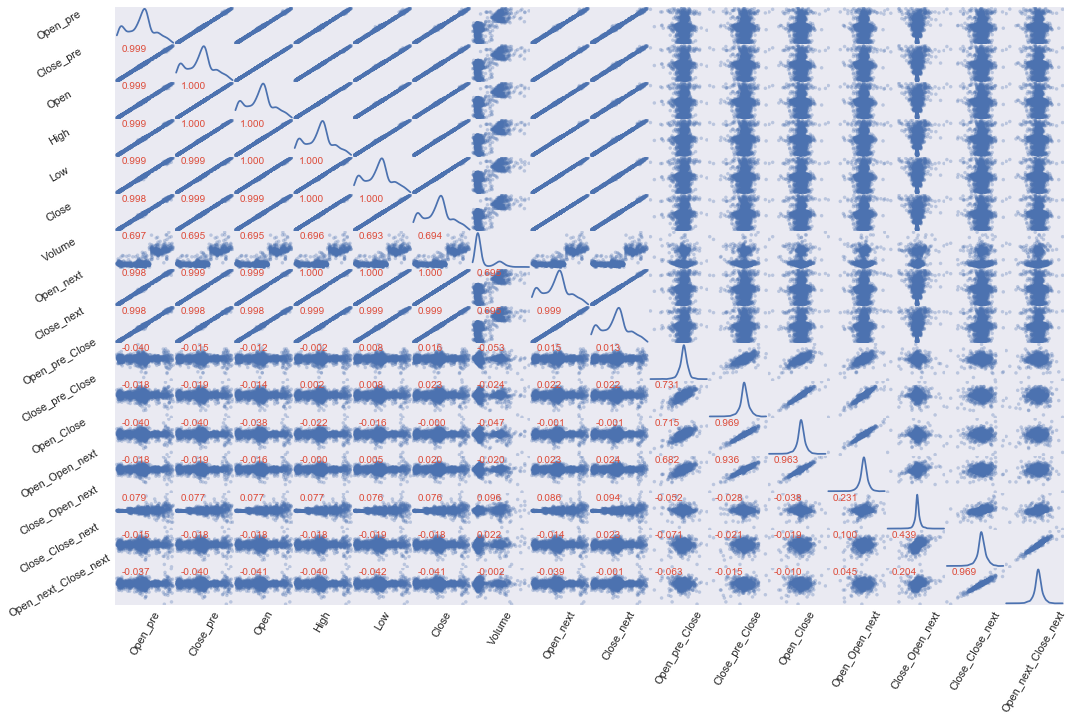

In [12]:
# print 'Produce a scatter matrix for each pair of features in the data'
data_corr = d  [[c for c in d.columns if c.find('up') < 0]]
mtrx_corr = data_corr.corr().as_matrix()
axs       = pd.plotting.scatter_matrix(data_corr, alpha = 0.3, figsize = (Page_size, Page_size*2/3), diagonal = 'kde')
for          i, j in  zip (*np.tril_indices_from(axs, k = 0)):
    ax = axs[i, j]
    if       i!=j:
        ax.annotate('%.3f' %mtrx_corr[i, j], ( 0.1, 0.8), xycoords = 'axes fraction', color = R)
    ax.get_yaxis().set_label_coords          (-0.9, 0.4)
    ax.xaxis.label.set_rotation(60)
    ax.yaxis.label.set_rotation(30)
    ax.set_xticks(())
    ax.set_yticks(())

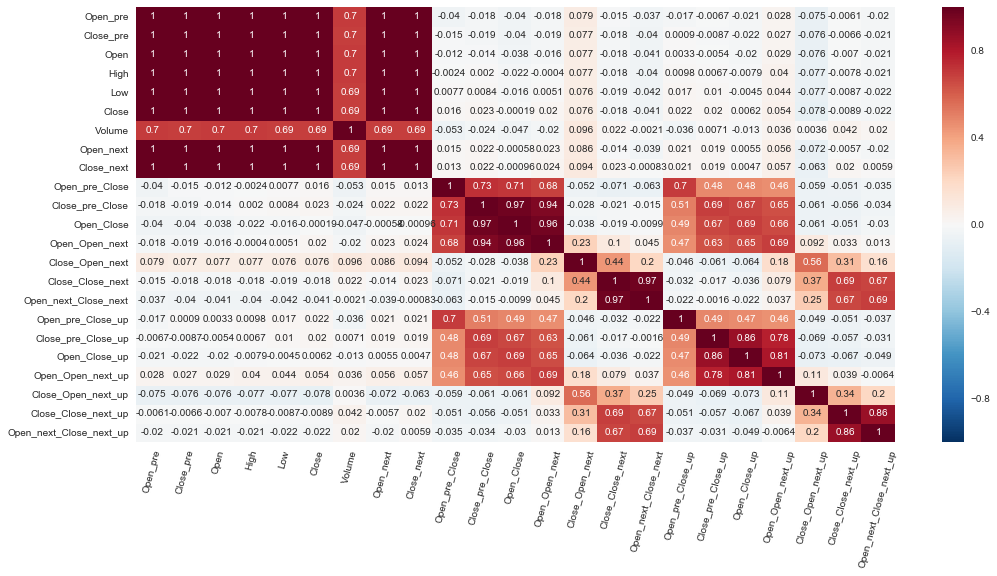

In [13]:
def corr_heatmap (data) :
    corr =        data  .corr()
    _, _ = plt.subplots (figsize     = (Page_size, Page_size/ 2))
    heat = sns.heatmap  (corr, annot =  True)
    heat.set_xticklabels(heat.get_xticklabels()  , rotation = 75)
corr_heatmap     (d   )

### Statistics Features
The statistics are calculated by the imported [stockstats](http://pypi.python.org/pypi/stockstats) module.
All the examples in the [Tutorial of the stockstats](http://pypi.python.org/pypi/stockstats) are listed below:

In [14]:
from stockstats import StockDataFrame
# from copy       import deepcopy
# s_copy  =              deepcopy(d     )
# s       = StockDataFrame.retype(s_copy)          # The data => StockDataFrame
s       = StockDataFrame.retype(d.copy())          # The data => StockDataFrame
stats   = ['volume_delta', 'open_-2_r', 'cr', 'cr-ma1', 'cr-ma2', 'cr-ma3', 'volume_-3,2,-1_max', 'volume_-3~1_min',
           'kdjk', 'kdjd', 'kdjj', 'open_2_sma', 'macd', 'macds', 'macdh', 'boll', 'boll_ub', 'boll_lb', 'cr-ma2_xu_cr-ma1_20_c',
           'rsi_6', 'rsi_12', 'wr_10', 'wr_6', 'cci', 'cci_20', 'tr', 'atr', 'dma', 'pdi', 'mdi', 'dx', 'adx', 'adxr',
           'trix', 'trix_9_sma', 'vr', 'vr_6_sma'] # Examples from the Tutorial of the stockstats

In [15]:
# [ s[stat] for stat in  stats]                    # Generate relative statistics
for             stat in  stats:                    # Generate relative statistics
    s[stat]                                        # The SettingWithCopyWarning might in stockstats.StockDataFrame

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
def display_corr(        data, corr,     n   = 5):
    print '\nTop {} Positive/Negative Correlation with {} of Statistics'                                      .format(n, corr)
    corr   =    (        data. corr()[corr].sort_values(by = corr, ascending = False)*100).applymap('{:6.2f}%'.format)
    display     (  concat    ([corr.head(n   = n)      .reset_index().rename(columns = {'index': 'Features'}) ,
                               corr.tail(n   = n)[::-1].reset_index().rename(columns = {'index': 'Features'})],
                  ['Positive Correlation', 'Negitive Correlation'])  .rename(index   = lambda i: i + 1))
def display_n   (        data, corr = False, right = '',
                                         n   = 5):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display ((       data. loc[:, right:] if right else data).describe())
        if          corr:
            display_corr(data, corr ,    n   = n)

_max = lambda s: max([int(n) for n in s.split('_') if n.isdigit()] or [1])

print 'Some statistics requiring multiple-day data might incomplete in the first few days and some are constant:'
display_n  (  s, right = stats[0])                          # display only new features

print '\nThe statistics with the most day number of data:'
stats_days = pd.DataFrame([(c, _max(c)) for c in s.columns],                 columns = ['Statistics', 'Days']
                                                               ).sort_values(by      =                'Days', ascending = False
                                                               ).reset_index(drop    = 1
                                                               ).     rename(index   = lambda i: i + 1)
display                 (stats_days.head())
stats_day  =         max(stats_days.Days  )
s_cplt     = s     .iloc[stats_day:-  stats_day                      ]
s_cplt     = s_cplt. loc[         :, (s_cplt  != s_cplt.iloc[0]).any()]
print 'Dropped the first and last {} days and constant statistics to guarantee the integrity'.format(stats_day)

Some statistics requiring multiple-day data might incomplete in the first few days and some are constant:


,volume_delta,open_-2_r,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",volume_-2_s,volume_0_s,volume_1_s,volume_-3~1_min,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,open_2_sma,close_26_ema,macd,macds,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,cr-ma1_20_c,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,wr_10,wr_6,middle_14_sma,cci,middle_20_sma,cci_20,tr,atr,close_10_sma,close_50_sma,dma,high_delta,um,low_delta,dm,pdm,pdm_14_ema,pdm_14,atr_14,pdi_14,pdi,mdm,mdm_14_ema,mdm_14,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,trix_9_sma,change,vr,vr_6_sma
count,1.566000e+03,1565.000000,1567.000000,1566.000000,1562.000000,1560.000000,1556.000000,1.564000e+03,1.566000e+03,1.565000e+03,1.567000e+03,1.565000e+03,1.567000e+03,1.566000e+03,1.567000e+03,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1566.000000,1567.000000,1566.000000,1566.000000,1543.0,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000,1567.000000,1567.000000,1566.000000,1567.000000,1566.000000,1566.000000,1566.000000,1567.000000,1567.000000,1567.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000,1567.000000,1567.000000,1566.000000,1566.000000,1566.000000,1567.000000,1567.000000,1567.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1563.000000
mean,7.963704e+05,0.096684,1965.492076,inf,124.022463,124.415433,124.897290,8.992478e+08,9.006032e+08,9.015516e+08,1.039004e+09,9.000359e+08,9.012557e+08,9.013996e+08,7.662189e+08,63.235438,63.203835,63.203835,63.188361,63.188361,63.234785,63.234785,1965.043497,1955.338746,6.018227,6.080915,-0.125375,1958.005085,23.114686,1958.005085,2004.649506,1912.190761,20.0,1965.570977,0.865868,inf,56.986391,inf,56.398568,36.384179,38.049978,1959.992878,27.313742,1957.453849,32.060715,18.605702,18.306328,1962.203735,1944.880187,17.323547,0.872676,4.660811,0.870268,4.705702,4.518500,4.497418,4.497418,18.306328,25.250958,25.250958,4.608130,4.566012,4.566012,23.166917,23.166917,31.643837,31.643837,31.748826,31.748826,31.851244,31.851244,0.045850,0.046456,0.048553,inf,124.972175
std,2.635306e+08,1.072285,378.076342,NaN,48.710956,46.343472,41.699368,6.683190e+08,6.689955e+08,6.696569e+08,7.498840e+08,6.688323e+08,6.692804e+08,6.694699e+08,5.740879e+08,30.668103,23.304411,23.304411,20.309376,20.309376,36.437987,36.437987,378.205704,375.471750,13.331871,12.140937,9.478684,376.809832,13.488080,376.809832,384.230382,370.722225,0.0,377.720353,15.678145,NaN,17.462330,NaN,12.123782,30.541609,31.084450,377.313273,105.830823,376.931567,108.398047,12.441796,7.122292,377.397041,373.423775,37.929022,11.890427,7.150698,15.066636,10.052271,7.186862,2.179613,2.179613,7.122292,9.468601,9.468601,10.072019,3.900456,3.900456,11.717936,11.717936,21.137743,21.137743,15.385488,15.385488,13.481207,13.481207,0.107835,0.103251,0.789631,NaN,52.052547
min,-1.854808e+09,-6.911553,1275.823333,35.036925,44.631415,52.251135,55.682846,1.839316e+08,1.839316e+08,1.839316e+08,3.782322e+08,1.839316e+08,1.839316e+08,1.839316e+08,1.839316e+08,0.000000,4.666604,4.666604,9.879499,9.879499,-22.128273,-22.128273,1278.055000,1308.040000,-47.639949,-40.305676,-61.144555,1308.040000,3.228371,1308.040000,1320.170742,1270.300916,20.0,1278.040000,-113.190000,0.067665,6.337629,0.174513,14.858333,0.000000,0.000000,1302.380000,-340.578134,1302.380000,-395.599439,3.700000,6.807037,1305.426000,1308.040000,-125.243000,-72.360000,0.000000,-121.800000,0.000000,0.000000,0.000000,0.000000,6.807037,4.532342,4.532342,0.000000,0.000000,0.000000,0.000000,0.000000,0.010822,0.010822,6.959956,6.959956,10.029961,10.029961,-0.368495,-0.346507,-4.097924,34.691762,46.627682
25%,-6.638344e+07,-0.414442,1677.423333,88.676661,90.856580,91.869615,94.586037,4.980904e+08,4.981410e+08,4.980993e+08,5.645439e+08,4.9809


The statistics with the most day number of data:


,Statistics,Days
1,close_50_sma,50
2,close_26_ema,26
3,close_20_sma,20
4,close_20_mstd,20
5,cr-ma1_20_c,20


Dropped the first and last 50 days and constant statistics to guarantee the integrity


#### Feature Comparison
The best statistics features are 6/12 days Relative Strength Index (RSI) and 6/10 days Williams Overbought/Oversold Index (WR) (the [stockstats](http://pypi.python.org/pypi/stockstats) changes all column names to lower case)

In [17]:
display_n(s_cplt, right = stats[0], corr = ['close_close_next_up', 'close_close_next'], n = 10)

,volume_delta,open_-2_r,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",volume_-2_s,volume_0_s,volume_1_s,volume_-3~1_min,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,open_2_sma,close_26_ema,macd,macds,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,wr_10,wr_6,middle_14_sma,cci,middle_20_sma,cci_20,tr,atr,close_10_sma,close_50_sma,dma,high_delta,um,low_delta,dm,pdm,pdm_14_ema,pdm_14,atr_14,pdi_14,pdi,mdm,mdm_14_ema,mdm_14,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,trix_9_sma,change,vr,vr_6_sma
count,1.467000e+03,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1.467000e+03,1.467000e+03,1.467000e+03,1.467000e+03,1.467000e+03,1.467000e+03,1.467000e+03,1.467000e+03,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000
mean,1.208499e+06,0.100910,1961.339877,123.268085,122.643153,122.083154,121.429436,8.555418e+08,8.577781e+08,8.616619e+08,9.918813e+08,8.566727e+08,8.589866e+08,8.604884e+08,7.282050e+08,63.217533,63.219200,63.219200,63.209416,63.209416,63.238768,63.238768,1960.798909,1950.083714,6.508157,6.424195,0.167924,1952.727127,22.279660,1952.727127,1997.286447,1908.167807,1960.947928,0.965842,1.839019,56.984594,1.476909,56.300056,36.403878,37.991064,1955.013042,27.133730,1952.154580,32.249174,17.776796,17.703401,1957.512030,1939.000084,18.511946,0.970757,4.534683,0.968691,4.362993,4.399141,4.381396,4.381396,17.703401,25.209453,25.209453,4.273626,4.268722,4.268722,22.964703,22.964703,31.321091,31.321091,31.245624,31.245624,31.168983,31.168983,0.047145,0.046904,0.050447,123.389049,123.341261
std,2.575166e+08,1.034917,348.963916,49.625397,45.904164,41.788571,35.557215,6.193901e+08,6.212628e+08,6.260240e+08,6.972381e+08,6.203583e+08,6.225477e+08,6.246262e+08,5.335512e+08,30.734866,23.356468,23.356468,20.369331,20.369331,36.439536,36.439536,348.682798,343.180983,13.088276,11.987505,8.765625,344.223483,11.630030,344.223483,346.302412,343.709634,348.661032,14.455482,1.520257,17.348007,0.762723,11.810231,30.624151,31.118583,345.488317,105.824999,344.180287,108.337501,10.372421,5.591834,346.550665,339.498288,37.338047,11.220998,6.897101,13.387798,8.601745,6.932841,2.014831,2.014831,5.591834,9.481993,9.481993,8.622611,3.087895,3.087895,11.156866,11.156866,20.883725,20.883725,14.921322,14.921322,12.628426,12.628426,0.107375,0.103242,0.763028,53.728965,51.322672
min,-1.854808e+09,-6.686069,1275.823333,35.036925,44.631415,52.251135,55.682846,1.839316e+08,1.839316e+08,1.839316e+08,3.782322e+08,1.839316e+08,1.839316e+08,1.839316e+08,1.839316e+08,0.000000,4.666604,4.666604,9.879499,9.879499,-22.128273,-22.128273,1278.055000,1324.033020,-47.639949,-40.305676,-47.470134,1310.821000,5.550314,1310.821000,1341.444192,1270.300916,1278.040000,-77.680000,0.067665,6.337629,0.174513,14.858333,0.000000,0.000000,1306.971190,-340.578134,1310.760500,-395.599439,3.700000,9.318114,1305.426000,1332.767800,-125.243000,-72.360000,0.000000,-103.880000,0.000000,0.000000,0.922930,0.922930,9.318114,4.532342,4.532342,0.000000,0.257627,0.257627,2.440395,2.440395,0.010822,0.010822,6.959956,6.959956,10.029961,10.029961,-0.368495,-0.346507,-3.941367,34.691762,46.627682
25%,-6.423875e+07,-0.402397,1691.201667,89.642022,91.304729,91.903318,94.342649,4.942710e+08,4.942710e+08,4.942710e+08,5.593024e+


Top 10 Positive/Negative Correlation with ['close_close_next_up', 'close_close_next'] of Statistics


Positive Correlation                                       \
                   Features close_close_next_up close_close_next   
1       close_close_next_up             100.00%           71.51%   
2   open_next_close_next_up              86.01%           69.66%   
3          close_close_next              71.51%          100.00%   
4      open_next_close_next              69.33%           97.70%   
5           close_open_next              36.76%           48.33%   
6        close_open_next_up              35.68%           40.68%   
7                    volume               5.51%            5.52%   
8                volume_0_s               5.51%            5.52%   
9                      wr_6               5.39%            6.36%   
10                    wr_10               5.33%            6.59%   

   Negitive Correlation                                       
               Features close_close_next_up close_close_next  
1         open_close_up              -7.82%           -4.62%  
2    close_pre_close_up              -6.62%           -3.58%  
3                rsi_12              -5.60%           -6.59%  
4            open_close              -5.59%           -1.63%  
5            close_-1_d              -5.53%           -1.75%  
6       close_pre_close              -5.53%           -1.75%  
7                 rsv_9              -5.44%           -6.35%  
8                 rsi_6              -5.43%           -6.33%  
9                  rs_6              -5.30%           -3.57%  
10               change              -5.04%           -1.50%

#### Feature Cleaned & Selection
Selecting the most correlated RSI6/12, WR6/10 and the popular rolling means (2 days simple moving average, C2M), Moving Average Convergence Divergence (MACD) and Bollinger Bands (Boll/u/l) suggested by proposal comment.
The first 11 days w/o sufficient data for 12-day rsi_12 are dropped as usual. 

In [18]:
X_stat, days_max = [], 0
for    col          ,   stat     in [
     ('RSI12'       ,  'rsi_12'     ),          # 12 days Relative Strength Index (RSI)
     ('RSI6'        ,  'rsi_6'      ),          #  6 days Relative Strength Index (RSI)
     ('WR10'        ,  'wr_10'      ),          # 10 days Williams Overbought/Oversold Index
     ('WR6'         ,  'wr_6'       ),          #  6 days Williams Overbought/Oversold Index
     ('C2M'         ,  'close_2_sma'),          #  2 days simple moving average (rolling means) on close price
     ('MACD'        ,  'macd'       ),          # Moving Average Convergence Divergence (MACD)
     ('Boll_u'      ,  'boll_ub'    ),          # Bollinger Upper Bands
     ('Boll'        ,  'boll'       ),          # Bollinger       Bands
     ('Boll_l'      ,  'boll_lb'    ),          # Bollinger Lower Bands
                                    ]:
    d[ col      ]   = s[stat        ]
    X_stat.append      ( col)
    days_cur     = _max(stat)
    if  days_max <  days_cur:
        days_max =  days_cur
        stat_max =      stat
        col_max  =       col
X_all   += X_stat
display(   d.loc[        :,       X_stat[0]:].head(n = days_max))
data_raw = d    [days_max:                  ]
print 'The first {} days w/o sufficient data for {}-day {} are dropped'.format(days_max - 1, days_max, stat_max)
display(   d.loc[        :,         col_max:].tail(n = days_max))

,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2012-01-19,NaN,NaN,0.408879,0.408879,1308.040,0.000000,NaN,1308.040000,NaN
2012-01-20,100.000000,100.000000,4.040816,4.040816,1311.270,0.144936,1320.405820,1311.270000,1302.134180
2012-01-21,100.000000,100.000000,0.448980,0.448980,1314.940,0.211966,1320.655884,1312.640000,1304.624116
2012-01-24,100.000000,100.000000,20.070310,20.070310,1315.690,0.259643,1320.837028,1313.480000,1306.122972
2012-01-25,82.315081,78.282565,24.384787,24.384787,1315.325,0.226364,1320.170742,1313.714000,1307.257258
2012-01-26,93.277192,93.218876,6.003752,6.003752,1320.355,0.690002,1327.389215,1315.771667,1304.154118
2012-01-27,64.232195,60.067847,35.404896,54.870485,1322.245,0.629801,1326.945454,1316.151429,1305.357403
2012-01-28,58.740379,53.754183,40.348399,62.531923,1317.380,0.479432,1326.167874,1316.173750,1306.179626
2012-01-31,51.191713,44.817317,48.163842,62.037599,1314.670,0.203292,1325.405843,1315.822222,1306.238602
2012-02-01,49.926777,43.257655,49.576271,63.856883,1312.710,-0.026457,1324.770671,1315.481000,1306.191329


The first 11 days w/o sufficient data for 12-day rsi_12 are dropped


,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-28,36.635903,32.670391,86.021337,82.557912,2635.585,-23.690448,2817.265582,2711.3105,2605.355418
2018-03-29,35.814648,31.387795,89.211923,87.530179,2608.810,-27.971332,2821.971635,2705.8690,2589.766365
2018-03-30,42.440658,43.841743,68.754262,49.922579,2622.935,-28.145115,2823.140737,2704.0290,2584.917263
2018-04-03,35.808719,32.279134,85.030387,76.789552,2611.375,-32.666283,2829.588913,2698.5605,2567.532087
2018-04-04,41.330727,42.352392,67.276357,49.867747,2598.165,-33.238067,2829.004256,2693.2360,2557.467744
2018-04-05,46.032940,50.547925,50.960397,24.871880,2629.570,-30.894956,2825.445263,2689.0645,2552.683737
2018-04-06,48.723799,55.141173,23.146321,7.811972,2653.765,-27.259243,2821.519188,2685.8665,2550.213812
2018-04-07,41.469541,40.591215,58.117044,57.160974,2633.655,-28.756400,2817.026839,2679.1415,2541.256161
2018-04-10,42.851439,43.265715,50.934039,49.814001,2608.815,-28.908458,2801.553832,2670.4710,2539.388168
2018-04-11,49.405984,55.388032,14.804100,15.446329,2635.015,-25.211313,2784.110756,2664.1635,2544.216244


#### Correlation of Current Data

In [19]:
display_corr(d, corr = ['Close_Close_next_up', 'Close_Close_next'], n = 10)


Top 10 Positive/Negative Correlation with ['Close_Close_next_up', 'Close_Close_next'] of Statistics


Positive Correlation                                       \
                   Features Close_Close_next_up Close_Close_next   
1       Close_Close_next_up             100.00%           69.07%   
2   Open_next_Close_next_up              86.13%           67.29%   
3          Close_Close_next              69.07%          100.00%   
4      Open_next_Close_next              66.76%           96.90%   
5        Close_Open_next_up              34.48%           37.33%   
6           Close_Open_next              30.96%           43.95%   
7                      WR10               5.50%            5.48%   
8                       WR6               5.07%            4.72%   
9                    Volume               4.17%            2.23%   
10        Open_Open_next_up               3.94%            7.92%   

   Negitive Correlation                                       
               Features Close_Close_next_up Close_Close_next  
1         Open_Close_up              -6.73%           -3.63%  
2                 RSI12              -5.81%           -6.38%  
3    Close_pre_Close_up              -5.75%           -1.69%  
4       Close_pre_Close              -5.65%           -2.12%  
5                  RSI6              -5.64%           -5.58%  
6                  MACD              -5.23%           -7.34%  
7            Open_Close              -5.12%           -1.86%  
8     Open_pre_Close_up              -5.07%           -3.21%  
9        Open_pre_Close              -5.05%           -7.06%  
10                Close              -0.89%           -1.84%

#### Exploratory Visualization of All Data
Checking data by stick plots which including all base features (`Open`, `High`, `Low`, `Close` and `Volume`) and Bollinger bands and zooming in the test data

Test Data


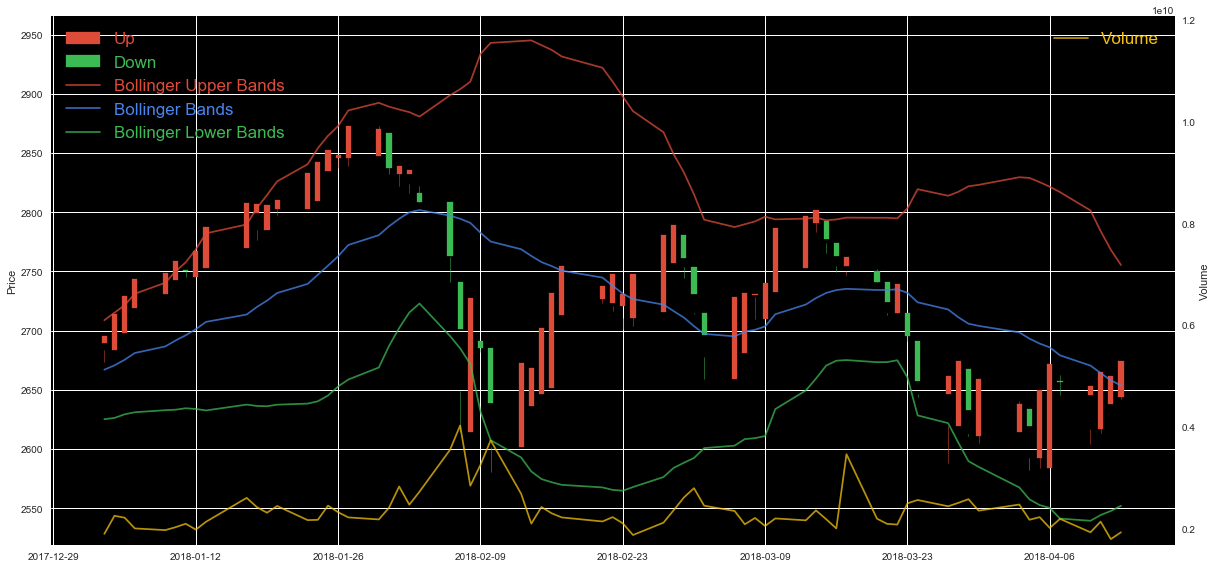

All Data


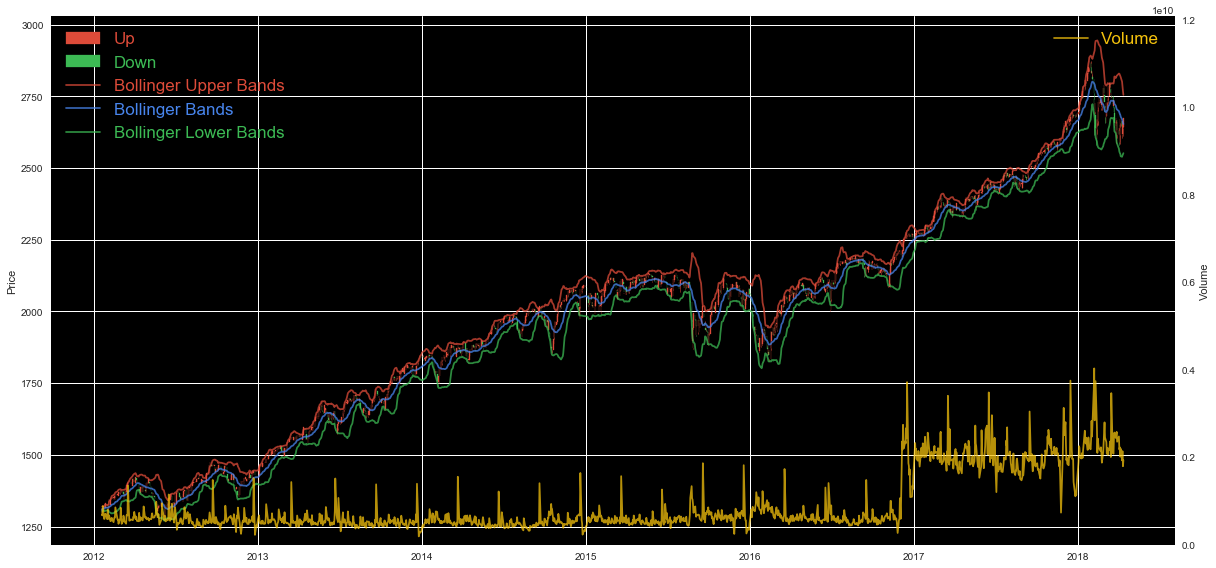

In [20]:
# Candle Stick Plot of open, high, low, close and Volume
from matplotlib.finance import candlestick_ohlc #, volume_overlay3
from matplotlib.patches import Patch

def FigStock(    x, size = 16, boll = False):
    x=           x. reset_index()
    x['index'] = x      ['index'].apply (dates.  date2num)
    fig, axP   = plt.subplots(figsize = (size , size/2  ))
    candlestick_ohlc(axP, x.values,    colorup = R ,   colordown = G, width = .5)
    axP. set_facecolor  ('#000000')
    axP.xaxis_date()
    axP. set_prop_cycle (  'color' ,      [      R ,  B    ,       G ])
    if  boll:
        boll = axP.plot (x['index'],    x[['Boll_u', 'Boll', 'Boll_l']].values, alpha = 0.75)
    axV      = axP.twinx()
    axV           .plot (x['index'],    x[ 'Volume'                   ].values, alpha = 0.75, label = 'Volume', color = Y)
    axV.grid      (False)
    axV.set_ylim  (None            ,  3*x[ 'Volume'].max())
    axV.set_ylabel(                        'Volume')
    axP.set_ylabel(                        'Price' )
    axV                   .legend( prop   = {'size': size}, loc = 'best'         ).get_texts()[0].set_color(Y)
    for text, c in zip(axP.legend([Patch(color = R), Patch(color = G)] +   boll,
                                  [            'Up',              'Down', 'Bollinger Upper Bands' ,
                                                                          'Bollinger Bands'       ,
                                                                          'Bollinger Lower Bands'],
                                   prop   = {'size': size}, loc = 'upper left'   ).get_texts()    ,
                                  [              R ,               G,      R, B, G]):
        text.set_color(c)
    plt.tight_layout()
    return axP, x

print 'Test Data'
FigStock(d[date_split:], Page_size, boll = True);
plt.show()
print  'All Data'
FigStock(d             , Page_size, boll = True);

Checking individual data and zoom in the test data according to scale groups of Prices, Price Changes and Indices

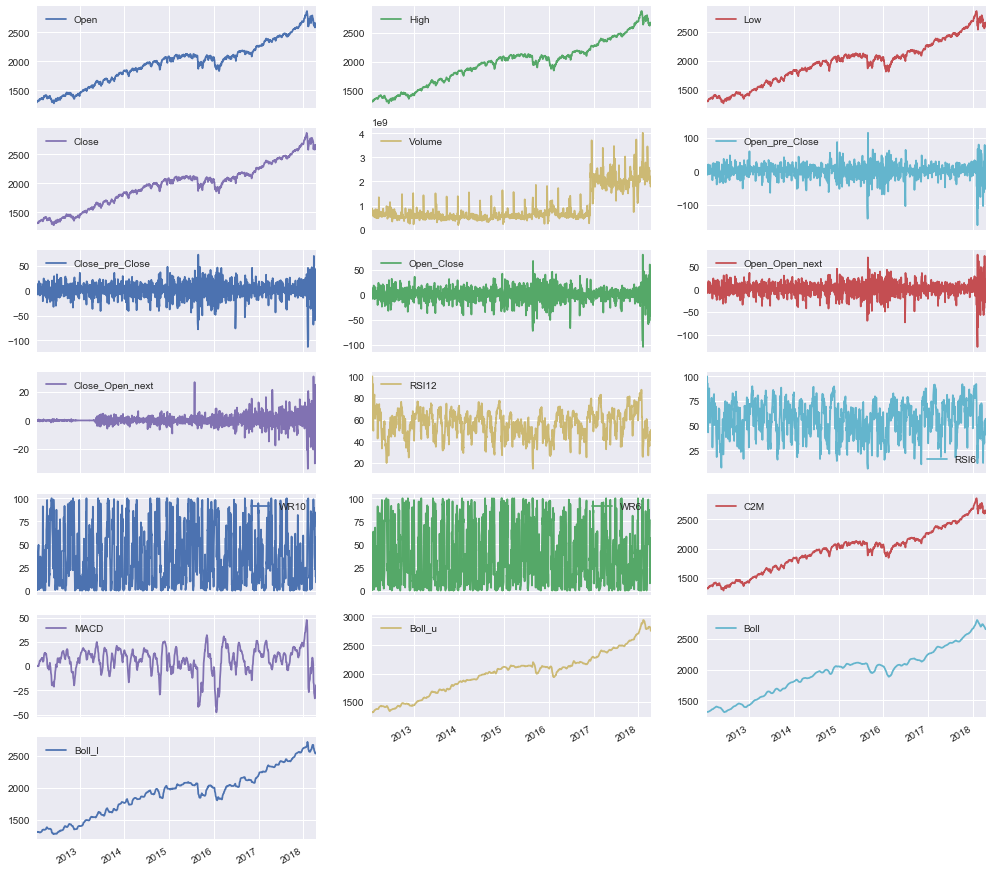

In [21]:
def subplot(data):
    data.plot(figsize = (Page_size, Page_size), subplots = True, layout = (len(data.columns)/3 + 1, 3));
subplot (d[X_base + X_vec + X_stat])

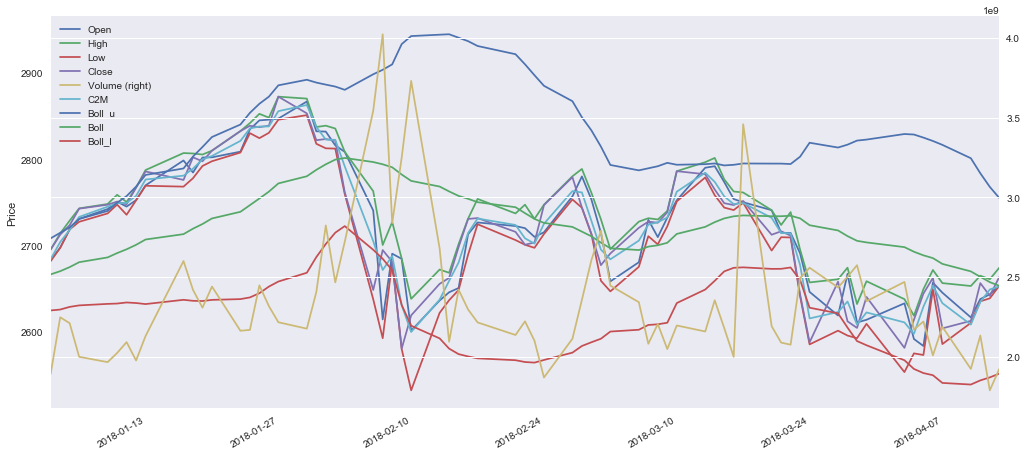

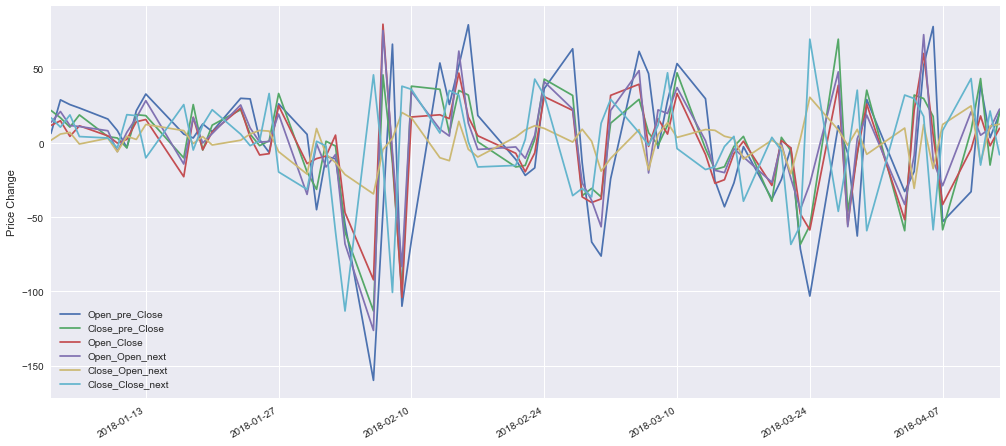

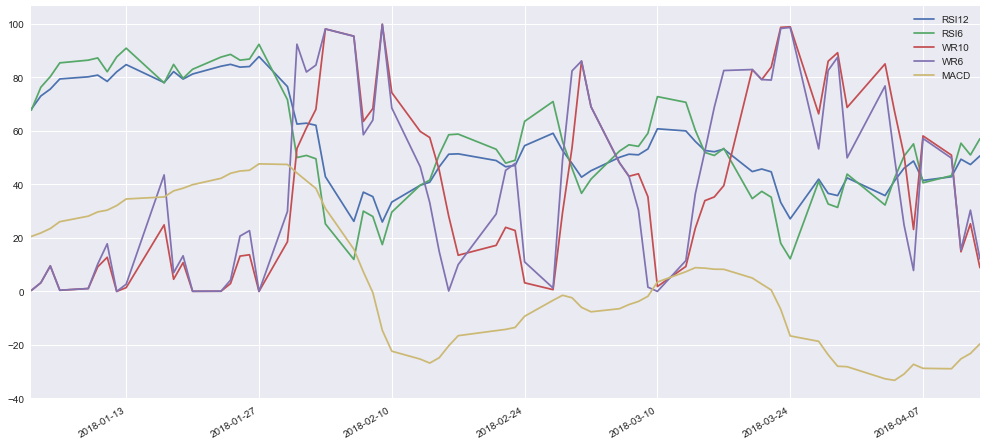

In [22]:
third_y =  ['C2M', 'Boll']
d_test  = d[date_split  :]
def plot( data,     ylabel = ''            , secondary_y = None       ):
    ax  = data.plot       (                  secondary_y = secondary_y, figsize = (Page_size, Page_size/2));
    ax        . set_ylabel(ylabel)

plot    ( d_test          [X_base + [x for x in X_stat if any([0 <= x.find(s) for s in third_y])]],
                          'Price'          ,              'Volume'                                )
plot    ( d_test          [X_vec  + ['Close_Close_next'                                         ]],
                          'Price Change'                                                          )
plot    ( d_test          [         [x for x in X_stat if all([0 >  x.find(s) for s in third_y])]])

----
## Data Preprocessing
### Log-Transforming the Skewed Continuous Feature

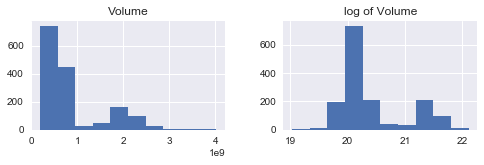

In [23]:
# Try Log-transform for the special feature
log           = ['Volume']
data_log      = data_raw     .copy  ()
data_log[log] = data_log[log].apply (          lambda x: np.log(x  + 1))
concat( [       data_raw[log],
                data_log[log].rename(columns = lambda c: 'log of ' + c)]).hist(figsize = (8, 2));

### Normalizing Numerical Features
Log-transformed data with MinMaxScaler is referred because it seems the most normal and cleanest

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
numerical = [c for c in data_raw.columns if c.find('up') < 0]
for data_scale, name in ((data_raw, 'data_raw'), (data_log, 'data_log'),):
    for scaler in (  RobustScaler(), StandardScaler(), MinMaxScaler(),):
        data_scaled                  =                           data_scale .copy()
        data_scaled[numerical]       =      scaler.fit_transform(data_scaled[numerical])
        print '\n[{} with {}]'.format(name, class_name(scaler))
#         display(data_scaled.head(n = 5)) # Show examples of records with scaling applied
        display(data_scaled.tail(n = 5))
        display(data_scaled.describe())


[data_raw with RobustScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-07,1.344701,1.364087,1.319901,1.319511,1.229206,1.236319,4.332576,1.259528,1.250875,-2.685840,...,False,-0.935857,-0.692697,0.562787,0.483232,1.303646,-2.367002,1.548220,1.411802,1.182152
2018-04-10,1.320835,1.242551,1.260533,1.312607,1.280168,1.254404,3.622042,1.303587,1.341716,-1.699732,...,True,-0.855235,-0.587836,0.422587,0.346724,1.251878,-2.376857,1.515799,1.393830,1.178418
2018-04-11,1.261602,1.260645,1.304541,1.337280,1.332107,1.345369,4.185895,1.314960,1.311207,1.826956,...,False,-0.472833,-0.112545,-0.282609,-0.291834,1.306480,-2.137246,1.479249,1.380755,1.188067
2018-04-12,1.305510,1.351656,1.315900,1.328945,1.339319,1.314818,3.260064,1.335589,1.356513,0.076529,...,True,-0.589072,-0.284725,-0.078321,-0.014839,1.336730,-2.006792,1.446226,1.367995,1.194958
2018-04-13,1.316843,1.321090,1.336505,1.356499,1.369622,1.360186,3.621815,1.383466,1.340531,0.872045,...,False,-0.400932,-0.046872,-0.398362,-0.353431,1.344150,-1.774744,1.419178,1.359135,1.203671


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,...,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,-0.077604,-0.078177,-0.079969,-0.085829,-0.069449,-0.081944,0.877330,-0.080729,-0.081887,-0.040555,...,-0.036602,-0.072944,-0.054564,0.140547,0.129406,-0.078205,-0.110427,-0.143915,-0.072686,-0.066429
std,0.776252,0.780955,0.778119,0.779702,0.778338,0.780672,1.806910,0.779171,0.779738,1.030346,...,1.072214,0.697107,0.681283,0.597286,0.578257,0.781549,0.866756,0.798928,0.775183,0.736407
min,-1.508417,-1.519291,-1.515832,-1.529934,-1.513302,-1.524115,-1.057570,-1.520063,-1.523832,-7.905922,...,-7.806691,-2.488396,-2.035709,-0.571560,-0.578830,-1.521377,-3.590841,-1.550969,-1.424476,-1.357793
25%,-0.671358,-0.672642,-0.674129,-0.684231,-0.658748,-0.676441,-0.212640,-0.674778,-0.676905,-0.508408,...,-0.492937,-0.560621,-0.522042,-0.402545,-0.399358,-0.671991,-0.557469,-0.756428,-0.674406,-0.658660
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.328642,0.327358,0.325871,0.315769,0.341252,0.323559,0.787360,0.325222,0.323095,0.491592,...,0.507063,0.439379,0.477958,0.597455,0.600642,0.328009,0.442531,0.243572,0.325594,0.341340
max,1.778748,1.801403,1.778863,1.767330,1.780417,1.794887,9.275652,1.778460,1.790617,5.493541,...,5.901115,1.765609,1.336547,1.380273,1.279190,1.782029,2.585703,1.816702,1.666168,1.545204



[data_raw with StandardScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-07,1.832863,1.847388,1.799621,1.802987,1.669033,1.689168,1.912856,1.720660,1.709793,-2.568201,...,False,-1.238247,-0.936966,0.707159,0.612080,1.768661,-2.604309,2.118688,1.915631,1.696049
2018-04-10,1.802107,1.691714,1.723300,1.794129,1.734530,1.712341,1.519498,1.777224,1.826332,-1.610828,...,True,-1.122558,-0.782998,0.472355,0.375936,1.702402,-2.615682,2.078094,1.892439,1.690978
2018-04-11,1.725777,1.714890,1.779875,1.825783,1.801283,1.828900,1.831652,1.791825,1.787192,1.813092,...,False,-0.573825,-0.085133,-0.708693,-0.728700,1.772289,-2.339148,2.032331,1.875567,1.704085
2018-04-12,1.782359,1.831466,1.794478,1.815090,1.810551,1.789754,1.319103,1.818309,1.845315,0.113673,...,True,-0.740624,-0.337942,-0.366557,-0.249528,1.811006,-2.188591,1.990984,1.859101,1.713445
2018-04-13,1.796964,1.792314,1.820967,1.850441,1.849497,1.847886,1.519372,1.879775,1.824812,0.886007,...,False,-0.470650,0.011295,-0.902553,-0.835256,1.820502,-1.920785,1.957117,1.847667,1.725281


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,...,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03
mean,6.208681e-16,4.735048e-16,-1.507904e-16,-8.753270e-17,-4.046781e-16,-7.588071e-16,4.379491e-16,-4.545132e-16,-6.270083e-16,-1.178050e-17,...,-8.567637e-18,-4.925678e-16,3.159093e-17,1.622139e-16,4.812156e-17,-1.088661e-15,8.938902e-17,-4.835003e-16,-3.926834e-16,5.097744e-16
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,...,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.843827e+00,-1.845917e+00,-1.845893e+00,-1.852720e+00,-1.855642e+00,-1.847939e+00,-1.071178e+00,-1.847859e+00,-1.849865e+00,-7.636170e+00,...,-7.249105e+00,-3.466082e+00,-2.908898e+00,-1.192623e+00,-1.225172e+00,-1.847147e+00,-4.016738e+00,-1.761744e+00,-1.744394e+00,-1.754165e+00
25%,-7.651448e-01,-7.614486e-01,-7.638310e-01,-7.677227e-01,-7.573680e-01,-7.617645e-01,-6.034174e-01,-7.626573e-01,-7.633467e-01,-4.542202e-01,...,-4.257376e-01,-6.997977e-01,-6.863941e-01,-9.095606e-01,-9.147041e-01,-7.600001e-01,-5.159296e-01,-7.669158e-01,-7.764797e-01,-8.044758e-01
50%,1.000050e-01,1.001360e-01,1.028048e-01,1.101147e-01,8.925607e-02,1.049991e-01,-4.856979e-01,1.036417e-01,1.050518e-01,3.937329e-02,...,3.414776e-02,1.046724e-01,8.011653e-02,-2.353856e-01,-2.238584e-01,1.000962e-01,1.274441e-01,1.801925e-01,9.379580e-02,9.023598e-02
75%,5.235117e-01,5.194467e-01,5.217325e-01,5.152315e-01,5.278338e-01,5.195945e-01,-4.980823e-02,5.211714e-01,5.195481e-01,5.166398e-01,...,5.072124e-01,7.351645e-01,7.818976e-01,7.652190e-01,8.151870e-01,5.199215e-01,6.381685e-01,4.851643e-01,5.139528e-01,5.539060e-01
max,2.392200e+00,2.407545e+00,2.389646e+00,2.377519e+00,2.377452e+00,2.404893e+00,4.649388e+00,2.386880e+00,2.402225e+00,5.372833e+00,...,5.539593e+00,2.638255e+00,2.042558e+00,2.076267e+00,1.989000e+00,2.380954e+00,3.111599e+00,2.454849e+00,2.243873e+00,2.189213e+00



[data_raw with MinMaxScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-07,0.867957,0.868306,0.860697,0.864185,0.832648,0.831706,0.521633,0.842677,0.837155,0.389574,...,False,0.364959,0.398253,0.581170,0.571610,0.855185,0.198143,0.920277,0.917698,0.874939
2018-04-10,0.860697,0.831706,0.842677,0.862091,0.848120,0.837155,0.452871,0.856035,0.864562,0.463167,...,True,0.383911,0.429348,0.509340,0.498140,0.839514,0.196547,0.910650,0.911883,0.873653
2018-04-11,0.842677,0.837155,0.856035,0.869573,0.863889,0.864562,0.507438,0.859482,0.855358,0.726363,...,False,0.473804,0.570290,0.148041,0.154463,0.856043,0.235341,0.899796,0.907653,0.876977
2018-04-12,0.856035,0.864562,0.859482,0.867046,0.866079,0.855358,0.417840,0.865736,0.869027,0.595729,...,True,0.446479,0.519232,0.252705,0.303544,0.865200,0.256462,0.889991,0.903524,0.879350
2018-04-13,0.859482,0.855358,0.865736,0.875402,0.875279,0.869027,0.452849,0.880251,0.864205,0.655098,...,False,0.490706,0.589765,0.088736,0.121311,0.867446,0.294031,0.881959,0.900657,0.882352


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,...,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,0.435273,0.433980,0.435811,0.437971,0.438365,0.434520,0.187250,0.436357,0.435048,0.586991,...,0.566837,0.567807,0.587483,0.364840,0.381178,0.436874,0.563489,0.417812,0.437382,0.444838
std,0.236146,0.235178,0.236173,0.236469,0.236310,0.235213,0.174864,0.236218,0.235254,0.076895,...,0.078219,0.163871,0.202026,0.306013,0.311222,0.236589,0.140330,0.237235,0.250816,0.253671
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.254645,0.254961,0.255472,0.256486,0.259449,0.255400,0.081768,0.256262,0.255526,0.552075,...,0.533547,0.453167,0.448859,0.086593,0.096593,0.257124,0.491112,0.235932,0.242691,0.240831
50%,0.458881,0.457522,0.460083,0.464001,0.459451,0.459209,0.102347,0.460831,0.459754,0.590018,...,0.569507,0.584954,0.603664,0.292833,0.311531,0.460548,0.581367,0.460546,0.460899,0.467721
75%,0.558858,0.556103,0.558990,0.559768,0.563058,0.556696,0.178544,0.559428,0.557235,0.626705,...,0.606498,0.688240,0.745396,0.598932,0.634801,0.559842,0.653014,0.532873,0.566248,0.585303
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



[data_log with RobustScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-07,1.344701,1.364087,1.319901,1.319511,1.229206,1.236319,2.390115,1.259528,1.250875,-2.685840,...,False,-0.935857,-0.692697,0.562787,0.483232,1.303646,-2.367002,1.548220,1.411802,1.182152
2018-04-10,1.320835,1.242551,1.260533,1.312607,1.280168,1.254404,2.159330,1.303587,1.341716,-1.699732,...,True,-0.855235,-0.587836,0.422587,0.346724,1.251878,-2.376857,1.515799,1.393830,1.178418
2018-04-11,1.261602,1.260645,1.304541,1.337280,1.332107,1.345369,2.344844,1.314960,1.311207,1.826956,...,False,-0.472833,-0.112545,-0.282609,-0.291834,1.306480,-2.137246,1.479249,1.380755,1.188067
2018-04-12,1.305510,1.351656,1.315900,1.328945,1.339319,1.314818,2.029255,1.335589,1.356513,0.076529,...,True,-0.589072,-0.284725,-0.078321,-0.014839,1.336730,-2.006792,1.446226,1.367995,1.194958
2018-04-13,1.316843,1.321090,1.336505,1.356499,1.369622,1.360186,2.159252,1.383466,1.340531,0.872045,...,False,-0.400932,-0.046872,-0.398362,-0.353431,1.344150,-1.774744,1.419178,1.359135,1.203671


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,...,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,-0.077604,-0.078177,-0.079969,-0.085829,-0.069449,-0.081944,0.438187,-0.080729,-0.081887,-0.040555,...,-0.036602,-0.072944,-0.054564,0.140547,0.129406,-0.078205,-0.110427,-0.143915,-0.072686,-0.066429
std,0.776252,0.780955,0.778119,0.779702,0.778338,0.780672,1.058608,0.779171,0.779738,1.030346,...,1.072214,0.697107,0.681283,0.597286,0.578257,0.781549,0.866756,0.798928,0.775183,0.736407
min,-1.508417,-1.519291,-1.515832,-1.529934,-1.513302,-1.524115,-2.050508,-1.520063,-1.523832,-7.905922,...,-7.806691,-2.488396,-2.035709,-0.571560,-0.578830,-1.521377,-3.590841,-1.550969,-1.424476,-1.357793
25%,-0.671358,-0.672642,-0.674129,-0.684231,-0.658748,-0.676441,-0.264206,-0.674778,-0.676905,-0.508408,...,-0.492937,-0.560621,-0.522042,-0.402545,-0.399358,-0.671991,-0.557469,-0.756428,-0.674406,-0.658660
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.328642,0.327358,0.325871,0.315769,0.341252,0.323559,0.735794,0.325222,0.323095,0.491592,...,0.507063,0.439379,0.477958,0.597455,0.600642,0.328009,0.442531,0.243572,0.325594,0.341340
max,1.778748,1.801403,1.778863,1.767330,1.780417,1.794887,3.483746,1.778460,1.790617,5.493541,...,5.901115,1.765609,1.336547,1.380273,1.279190,1.782029,2.585703,1.816702,1.666168,1.545204



[data_log with StandardScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-07,1.832863,1.847388,1.799621,1.802987,1.669033,1.689168,1.844455,1.720660,1.709793,-2.568201,...,False,-1.238247,-0.936966,0.707159,0.612080,1.768661,-2.604309,2.118688,1.915631,1.696049
2018-04-10,1.802107,1.691714,1.723300,1.794129,1.734530,1.712341,1.626377,1.777224,1.826332,-1.610828,...,True,-1.122558,-0.782998,0.472355,0.375936,1.702402,-2.615682,2.078094,1.892439,1.690978
2018-04-11,1.725777,1.714890,1.779875,1.825783,1.801283,1.828900,1.801676,1.791825,1.787192,1.813092,...,False,-0.573825,-0.085133,-0.708693,-0.728700,1.772289,-2.339148,2.032331,1.875567,1.704085
2018-04-12,1.782359,1.831466,1.794478,1.815090,1.810551,1.789754,1.503464,1.818309,1.845315,0.113673,...,True,-0.740624,-0.337942,-0.366557,-0.249528,1.811006,-2.188591,1.990984,1.859101,1.713445
2018-04-13,1.796964,1.792314,1.820967,1.850441,1.849497,1.847886,1.626303,1.879775,1.824812,0.886007,...,False,-0.470650,0.011295,-0.902553,-0.835256,1.820502,-1.920785,1.957117,1.847667,1.725281


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,...,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03,1.555000e+03
mean,6.208681e-16,4.735048e-16,-1.507904e-16,-8.753270e-17,-4.046781e-16,-7.588071e-16,1.521898e-15,-4.545132e-16,-6.270083e-16,-1.178050e-17,...,-8.567637e-18,-4.925678e-16,3.159093e-17,1.622139e-16,4.812156e-17,-1.088661e-15,8.938902e-17,-4.835003e-16,-3.926834e-16,5.097744e-16
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,...,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.843827e+00,-1.845917e+00,-1.845893e+00,-1.852720e+00,-1.855642e+00,-1.847939e+00,-2.351669e+00,-1.847859e+00,-1.849865e+00,-7.636170e+00,...,-7.249105e+00,-3.466082e+00,-2.908898e+00,-1.192623e+00,-1.225172e+00,-1.847147e+00,-4.016738e+00,-1.761744e+00,-1.744394e+00,-1.754165e+00
25%,-7.651448e-01,-7.614486e-01,-7.638310e-01,-7.677227e-01,-7.573680e-01,-7.617645e-01,-6.637197e-01,-7.626573e-01,-7.633467e-01,-4.542202e-01,...,-4.257376e-01,-6.997977e-01,-6.863941e-01,-9.095606e-01,-9.147041e-01,-7.600001e-01,-5.159296e-01,-7.669158e-01,-7.764797e-01,-8.044758e-01
50%,1.000050e-01,1.001360e-01,1.028048e-01,1.101147e-01,8.925607e-02,1.049991e-01,-4.140610e-01,1.036417e-01,1.050518e-01,3.937329e-02,...,3.414776e-02,1.046724e-01,8.011653e-02,-2.353856e-01,-2.238584e-01,1.000962e-01,1.274441e-01,1.801925e-01,9.379580e-02,9.023598e-02
75%,5.235117e-01,5.194467e-01,5.217325e-01,5.152315e-01,5.278338e-01,5.195945e-01,2.812206e-01,5.211714e-01,5.195481e-01,5.166398e-01,...,5.072124e-01,7.351645e-01,7.818976e-01,7.652190e-01,8.151870e-01,5.199215e-01,6.381685e-01,4.851643e-01,5.139528e-01,5.539060e-01
max,2.392200e+00,2.407545e+00,2.389646e+00,2.377519e+00,2.377452e+00,2.404893e+00,2.877871e+00,2.386880e+00,2.402225e+00,5.372833e+00,...,5.539593e+00,2.638255e+00,2.042558e+00,2.076267e+00,1.989000e+00,2.380954e+00,3.111599e+00,2.454849e+00,2.243873e+00,2.189213e+00



[data_log with MinMaxScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-07,0.867957,0.868306,0.860697,0.864185,0.832648,0.831706,0.802389,0.842677,0.837155,0.389574,...,False,0.364959,0.398253,0.581170,0.571610,0.855185,0.198143,0.920277,0.917698,0.874939
2018-04-10,0.860697,0.831706,0.842677,0.862091,0.848120,0.837155,0.760688,0.856035,0.864562,0.463167,...,True,0.383911,0.429348,0.509340,0.498140,0.839514,0.196547,0.910650,0.911883,0.873653
2018-04-11,0.842677,0.837155,0.856035,0.869573,0.863889,0.864562,0.794208,0.859482,0.855358,0.726363,...,False,0.473804,0.570290,0.148041,0.154463,0.856043,0.235341,0.899796,0.907653,0.876977
2018-04-12,0.856035,0.864562,0.859482,0.867046,0.866079,0.855358,0.737184,0.865736,0.869027,0.595729,...,True,0.446479,0.519232,0.252705,0.303544,0.865200,0.256462,0.889991,0.903524,0.879350
2018-04-13,0.859482,0.855358,0.865736,0.875402,0.875279,0.869027,0.760673,0.880251,0.864205,0.655098,...,False,0.490706,0.589765,0.088736,0.121311,0.867446,0.294031,0.881959,0.900657,0.882352


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,...,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,0.435273,0.433980,0.435811,0.437971,0.438365,0.434520,0.449689,0.436357,0.435048,0.586991,...,0.566837,0.567807,0.587483,0.364840,0.381178,0.436874,0.563489,0.417812,0.437382,0.444838
std,0.236146,0.235178,0.236173,0.236469,0.236310,0.235213,0.191283,0.236218,0.235254,0.076895,...,0.078219,0.163871,0.202026,0.306013,0.311222,0.236589,0.140330,0.237235,0.250816,0.253671
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.254645,0.254961,0.255472,0.256486,0.259449,0.255400,0.322772,0.256262,0.255526,0.552075,...,0.533547,0.453167,0.448859,0.086593,0.096593,0.257124,0.491112,0.235932,0.242691,0.240831
50%,0.458881,0.457522,0.460083,0.464001,0.459451,0.459209,0.370512,0.460831,0.459754,0.590018,...,0.569507,0.584954,0.603664,0.292833,0.311531,0.460548,0.581367,0.460546,0.460899,0.467721
75%,0.558858,0.556103,0.558990,0.559768,0.563058,0.556696,0.503465,0.559428,0.557235,0.626705,...,0.606498,0.688240,0.745396,0.598932,0.634801,0.559842,0.653014,0.532873,0.566248,0.585303
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Preprocessing
Original Scaled/Normalized Features and 29-day previous-data-concatenated Features are shown below and the best day range will be tried later

In [25]:
day_range_Max =  30

pre           =  '{}_pre{}'
def pre_data  (                         X0,             day_range_Max = 2):  # Combine previous daily data
    X         =                         X0.copy()
    for shf in range       ( 1,                         day_range_Max    ):
        X     =  concat    ([X,         X0.shift(shf).rename(columns = lambda c: pre.format(c, shf))])
    return                   X                        [ day_range_Max - 1 :] # Dropout days which lack previous daily data

pre_feature   = lambda feature, shf: list(feature) + [pre.format(f, s) for s in range(1, shf) for f in feature]

print      'Scaled/Normalized Features:'
X_display                  (data_scaled)

X             = pre_data   (data_scaled[X_all        ], day_range_Max      )
y             =             data_scaled[y_clf + y_rgr][ day_range_Max - 1 :]
X_pre         =[pre_feature( f,                         day_range_Max      ) for f in [X_base, X_vec, X_up, X_stat]]

print      '\n{}-day Previous-data-concated Features:'.format(day_range_Max - 1)
display                    ( X.tail()  );
# y_display                  ( y         );

Scaled/Normalized Features:


Base Features ~  X_base                                          \
                              Open      High       Low     Close    Volume   
2018-04-07                0.860697  0.864185  0.832648  0.831706  0.802389   
2018-04-10                0.842677  0.862091  0.848120  0.837155  0.760688   
2018-04-11                0.856035  0.869573  0.863889  0.864562  0.794208   
2018-04-12                0.859482  0.867046  0.866079  0.855358  0.737184   
2018-04-13                0.865736  0.875402  0.875279  0.869027  0.760673   

           Vector Features ~  X_vec                                            \
                     Open_pre_Close Close_pre_Close Open_Close Open_Open_next   
2018-04-07                 0.389574        0.294604   0.339860       0.482292   
2018-04-10                 0.463167        0.654987   0.542333       0.728624   
2018-04-11                 0.726363        0.843186   0.664262       0.650827   
2018-04-12                 0.595729        0.529396   0.554917       0.672857   
2018-04-13                 0.655098        0.725441   0.619244       0.737713   

                           Up Features ~  X_up                     \
           Close_Open_next   Open_pre_Close_up Close_pre_Close_up   
2018-04-07        0.718314               False              False   
2018-04-10        0.910498               False               True   
2018-04-11        0.324598                True               True   
2018-04-12        0.701916                True              False   
2018-04-13        0.721379                True               True   

                                                               
           Open_Close_up Open_Open_next_up Close_Open_next_up  
2018-04-07         False             False               True  
2018-04-10         False              True               True  
2018-04-11          True              True              False  
2018-04-12         False              True               True  
2018-04-13          True              True               True


29-day Previous-data-concated Features:


,Open,High,Low,Close,Volume,Open_pre_Close,Close_pre_Close,Open_Close,Open_Open_next,Close_Open_next,...,Close_Open_next_up_pre29,RSI12_pre29,RSI6_pre29,WR10_pre29,WR6_pre29,C2M_pre29,MACD_pre29,Boll_u_pre29,Boll_pre29,Boll_l_pre29
2018-04-07,0.860697,0.864185,0.832648,0.831706,0.802389,0.389574,0.294604,0.339860,0.482292,0.718314,...,True,0.543129,0.665236,0.032111,0.110217,0.913210,0.402346,0.962835,0.949557,0.893254
2018-04-10,0.842677,0.862091,0.848120,0.837155,0.760688,0.463167,0.654987,0.542333,0.728624,0.910498,...,True,0.606781,0.751386,0.006574,0.012550,0.937070,0.464874,0.951752,0.946429,0.899095
2018-04-11,0.856035,0.869573,0.863889,0.864562,0.794208,0.726363,0.843186,0.664262,0.650827,0.324598,...,True,0.518918,0.577628,0.295061,0.491026,0.936117,0.484698,0.940156,0.942766,0.904405
2018-04-12,0.859482,0.867046,0.866079,0.855358,0.737184,0.595729,0.529396,0.554917,0.672857,0.701916,...,True,0.452057,0.461111,0.536926,0.824250,0.915371,0.474914,0.930720,0.939124,0.907369
2018-04-13,0.865736,0.875402,0.875279,0.869027,0.760673,0.655098,0.725441,0.619244,0.737713,0.721379,...,False,0.381866,0.352470,0.860849,0.860849,0.894359,0.437267,0.919090,0.934223,0.910176


### Split Data
Split the data (both features and their labels) into training and test sets.
Data before 2018 will be used for training and the other for testing.

In [26]:
def Split1(        y, date):
    return         y[:date],        y[ date:]
def Split (        X,               y, date):
    return Split1( X, date), Split1(y, date)

(X_train,          X_test ),       (y_train, y_test) = Split(X, y, date_split)

print  'Training set has {} samples, tail:'.format(X_train.shape[0]) # Show the results of the split
X_display(X_train, X_pre);
y_display(y_train       );
print '\nThe date to split: ', date_split.strftime('%d %b %Y')
print '\nTesting set has {} samples, head:'.format(X_test .shape[0])
X_display(X_test , X_pre);
y_display(y_test        );

Training set has 1456 samples, tail:


Base Features ~  X_base                                          \
                              Open      High       Low     Close    Volume   
2017-12-23                0.884857  0.882087  0.890613  0.881160  0.663970   
2017-12-27                0.881629  0.880445  0.890506  0.879379  0.579744   
2017-12-28                0.883523  0.882269  0.891105  0.880708  0.604336   
2017-12-29                0.886039  0.883539  0.893490  0.883793  0.588721   
2017-12-30                0.887958  0.886344  0.887761  0.875059  0.647104   

                                                                    ...       \
           Open_pre1 High_pre1  Low_pre1 Close_pre1 Volume_pre1     ...        
2017-12-23  0.884102  0.886671  0.893307   0.881931    0.764933     ...        
2017-12-27  0.884857  0.882087  0.890613   0.881160    0.663970     ...        
2017-12-28  0.881629  0.880445  0.890506   0.879379    0.579744     ...        
2017-12-29  0.883523  0.882269  0.891105   0.880708    0.604336     ...        
2017-12-30  0.886039  0.883539  0.893490   0.883793    0.588721     ...        

           Statistics Features ~  X_stat                                    \
                            Boll_l_pre28 RSI12_pre29 RSI6_pre29 WR10_pre29   
2017-12-23                      0.882444    0.627961   0.517548   0.477147   
2017-12-27                      0.883988    0.649814   0.570448   0.394814   
2017-12-28                      0.884408    0.569531   0.437084   0.588331   
2017-12-29                      0.885784    0.417400   0.246940   0.818802   
2017-12-30                      0.885936    0.597805   0.581406   0.287592   

                                                                                
           WR6_pre29 C2M_pre29 MACD_pre29 Boll_u_pre29 Boll_pre29 Boll_l_pre29  
2017-12-23  0.479635  0.823518   0.655688     0.784466   0.847401     0.880889  
2017-12-27  0.396872  0.823587   0.647377     0.784753   0.848313     0.882444  
2017-12-28  0.591398  0.822505   0.634188     0.784572   0.848967     0.883988  
2017-12-29  0.811415  0.816127   0.610396     0.784401   0.849080     0.884408  
2017-12-30  0.136336  0.818263   0.608090     0.784622   0.849869     0.885784  

[5 rows x 720 columns]

y (Classification)                         y (Regressions)  \
           Close_Close_next_up Open_next_Close_next_up       Open_next   
2017-12-23               False                    True        0.881629   
2017-12-27                True                    True        0.883523   
2017-12-28                True                    True        0.886039   
2017-12-29               False                   False        0.887958   
2017-12-30                True                    True        0.884548   

                       
           Close_next  
2017-12-23   0.879379  
2017-12-27   0.880708  
2017-12-28   0.883793  
2017-12-29   0.875059  
2017-12-30   0.888979


The date to split:  01 Jan 2018

Testing set has 70 samples, head:


Base Features ~  X_base                                          \
                              Open      High       Low     Close    Volume   
2018-04-07                0.860697  0.864185  0.832648  0.831706  0.802389   
2018-04-10                0.842677  0.862091  0.848120  0.837155  0.760688   
2018-04-11                0.856035  0.869573  0.863889  0.864562  0.794208   
2018-04-12                0.859482  0.867046  0.866079  0.855358  0.737184   
2018-04-13                0.865736  0.875402  0.875279  0.869027  0.760673   

                                                                    ...       \
           Open_pre1 High_pre1  Low_pre1 Close_pre1 Volume_pre1     ...        
2018-04-07  0.867957  0.873742  0.872597   0.868306    0.774703     ...        
2018-04-10  0.860697  0.864185  0.832648   0.831706    0.802389     ...        
2018-04-11  0.842677  0.862091  0.848120   0.837155    0.760688     ...        
2018-04-12  0.856035  0.869573  0.863889   0.864562    0.794208     ...        
2018-04-13  0.859482  0.867046  0.866079   0.855358    0.737184     ...        

           Statistics Features ~  X_stat                                    \
                            Boll_l_pre28 RSI12_pre29 RSI6_pre29 WR10_pre29   
2018-04-07                      0.899095    0.543129   0.665236   0.032111   
2018-04-10                      0.904405    0.606781   0.751386   0.006574   
2018-04-11                      0.907369    0.518918   0.577628   0.295061   
2018-04-12                      0.910176    0.452057   0.461111   0.536926   
2018-04-13                      0.915906    0.381866   0.352470   0.860849   

                                                                                
           WR6_pre29 C2M_pre29 MACD_pre29 Boll_u_pre29 Boll_pre29 Boll_l_pre29  
2018-04-07  0.110217  0.913210   0.402346     0.962835   0.949557     0.893254  
2018-04-10  0.012550  0.937070   0.464874     0.951752   0.946429     0.899095  
2018-04-11  0.491026  0.936117   0.484698     0.940156   0.942766     0.904405  
2018-04-12  0.824250  0.915371   0.474914     0.930720   0.939124     0.907369  
2018-04-13  0.860849  0.894359   0.437267     0.919090   0.934223     0.910176  

[5 rows x 720 columns]

y (Classification)                         y (Regressions)  \
           Close_Close_next_up Open_next_Close_next_up       Open_next   
2018-04-07                True                   False        0.842677   
2018-04-10                True                    True        0.856035   
2018-04-11               False                   False        0.859482   
2018-04-12                True                    True        0.865736   
2018-04-13               False                   False        0.880251   

                       
           Close_next  
2018-04-07   0.837155  
2018-04-10   0.864562  
2018-04-11   0.855358  
2018-04-12   0.869027  
2018-04-13   0.864205

----
## Evaluating Model Performance
### Metrics and the Naive Predictor
Use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 1$, precision and recall are balanced. This is called the **F$_{1}$ score** (or F-score for simplicity).

### Target Model
- [**Ensemble Tree Gradient Boosting Classifier**](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
    - Application: Ranking webs for the commercial search engines, e.g., Yahoo and Yandex (Ref.: [`wikipedia/Gradient_boosting`](https://wikipedia.org/wiki/Gradient_boosting))
    - Pros (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting))
        - Natural handling of mixed-type data (heterogeneous features)
        - High predictive power
        - Robustness to outliers in output space (via robust loss functions)
        - Fast training & prediction (based on the following experiment)
    - Cons (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting))
        - Scalability, due to the sequential nature of boosting it can hardly be parallelized
    - Natural handling of mixed-type data (heterogeneous features) and more powerful for classification when the number of samples < 100K (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) & [`machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))
    
### Benchmark Model
- [**Support Vector Machines**](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
    - Application: Text and hypertext categorization (Ref.: [`wikipedia/Support_vector_machine`](https://wikipedia.org/wiki/Support_vector_machine))
    - Pros (Ref.: [`sklearn/svm`](http://scikit-learn.org/stable/modules/svm.html))
        - Effective in high dimensional spaces (even when the number of dimensions is greater than the number of samples)
        - Memory efficient (use some training points for the decision function ~ support vectors)
        - Versatile in the decision function (common and custom kernel functions)
    - Cons (Ref.: [`youtube/Udacity/SVM Strengths and Weaknesses`](https://youtu.be/U9-ZsbaaGAs) & [`sklearn/svm`](http://scikit-learn.org/stable/modules/svm.html))
        - When the number of features is much greater than the number of samples, need specified kernel function and regularization to avoid over-fitting
        - Do not directly provide probability estimates
        - High computation cost when training large data
        - Low noise/overlapping tolerance
    - Efficient for classification when the number of samples < 100K (Ref.: [`sklearn/machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))
    
### Creating a Training and Predicting Pipeline
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [27]:
from sklearn.metrics import accuracy_score,  fbeta_score, confusion_matrix, classification_report
beta = 1

def clf_scores                                           (                 y,               predict      , beta = beta):
    return                               (accuracy_score (                 y,               predict                   ),
                                             fbeta_score (                 y,               predict      , beta = beta))
                                                                                    
def train_predict                       (     clf,        X_train, X_test, y_train, y_test,                beta = beta):
    results                             = {}                                        
    clf                                          .fit    (X_train,         y_train        )
    predict_train                       =     clf.predict(X_train                         )
    predict_test                        =     clf.predict(         X_test                 )
    (results['acc_train'             ],                                             
     results['f{}_train'.format(beta)]) =     clf_scores (                 y_train,         predict_train, beta = beta)
    (results['acc_test'              ],                                             
     results['f{}_test' .format(beta)]) =     clf_scores (                          y_test, predict_test , beta = beta)
    return results, clf, predict_test

In [28]:
from sklearn.svm          import SVC
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.ensemble     import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from copy                 import deepcopy

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category = sklearn.exceptions.UndefinedMetricWarning)

label        =  'Close_Close_next_up'
random_state = random_state
fbeta        = 'f' + str(beta)
csv          = lambda l: l[0] if len(l) < 2 else '{} & {}'.format(', '.join(l[:-1]), l[-1])

def plot_day(score, sels = ['acc', '_f'], size = Page_size):
    for sel in list(sels):
        (score[[c for c in score.keys() if 0 <= c.find(sel)]]*100).plot(figsize = (size, size/2), xticks = score.index)
        plt.ylabel(         '%')
        plt.xlabel( 'Days of X')

up_down_matrix =    lambda true, predict: pd.DataFrame(
       confusion_matrix   (true, predict), index        = ['Down_true'   ,   'Up_true'   ] ,
                                           columns      = ['Down_predict',   'Up_predict']). iloc     [::-1].iloc[:, ::-1]
clf_report     =    lambda true, predict: classification_report(
                           true, predict , target_names = [  'Up'        , 'Down'        ] , labels = [1, 0])

def    confusion_report   (true, predict):
    display(up_down_matrix(true, predict))
    print       clf_report(true, predict)

GBC  =  GradientBoostingClassifier(random_state = random_state)
svc  =  SVC                       (random_state = random_state)
clfs = [
        svc                                                    ,
        GBC                                                    ,
#         KNeighborsClassifier      (                           ),
       ]

def score_day(X = X, y = y, clfs = clfs, feature_days_max = day_range_Max, feature = X_all, label = label, output = 1,
              train_test_split = date_split, scorer = fbeta, beta = beta, random_state = random_state, size = Page_size):
    results,    scores = {} , {} 
    best     = {scorer: 0}
#     print "Train: {} ~ {}; Test {} ~ {}".format(y_train.index[0], y_train.index[-1], y_test.index[0], y_test.index[-1])
#     feature     = list(set   (feature))
    featureset  = pre_feature(feature, feature_days_max)
    feature_len = len        (feature )
    for features, days in [  (featureset[:d*feature_len], d) for d in range(1, feature_days_max + 1)]:
        (                 X_train,            X_test), (y_train, y_test) = Split  (X[features], y[label], train_test_split)
        for clf0 in deepcopy(clfs):
            clf_name =  class_name(clf0)
            results[clf_name],     clf, predict_test =    train_predict(
                    clf0, X_train,            X_test ,  y_train, y_test)
            for l, s in [(clf_name + '_' +              s , results[clf_name][s]) for s in results[clf_name].keys()]:
                scores.setdefault(l, {})[days] =        s
                if 0 <= l.find (  scorer + '_test') and s > best[scorer]:
                    best.update({ scorer   :            s ,
                                 'clf'     :          clf ,
                                 'feature' :      feature ,
                                 'features':      features,
                                 'days'    :         days ,
                                 'Xy'      :    {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test},
                                 'predict' :                                                                   predict_test ,
                                })
    
    if  output:
        print ('The best classifier is {} with {:.2f}% {}-score and {}-day '
#               +'{} '
              +'features to predict {} '
#               +'since {}'
              ).format(class_name(best['clf']), 100*best[scorer], scorer, best['days'],
#                        csv(feature),
                       label,
#                        train_test_split
                      )
        confusion_report(best['Xy']['y_test'], best['predict'])
        plot_day(pd.DataFrame(scores), size = size)
    return best

### Initial Model Evaluation
Using the default settings and fixed `random_state` for each model.
Applying originally proposed base features (`Open`, `High`, `Low`, `Close`, `Volume`) from the raw data and trying the concatenated previous features to 29 days (totally 30 days).
The confusion matrix and classification report are clear to show that the predictions are **always up**.
The reason might be **the prices in 2018 are usually higher than previous years** even after normalization.
Therefore, the **relative price change Vectors** will be involved besides the **absolute prices**.

The best classifier is SVC with 71.56% f1-score and 1-day features to predict Close_Close_next_up 


,Up_predict,Down_predict
Up_true,39,0
Down_true,31,0


             precision    recall  f1-score   support

         Up       0.56      1.00      0.72        39
       Down       0.00      0.00      0.00        31

avg / total       0.31      0.56      0.40        70



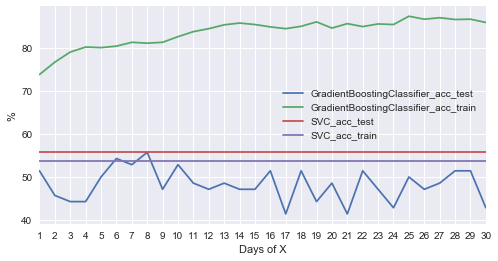

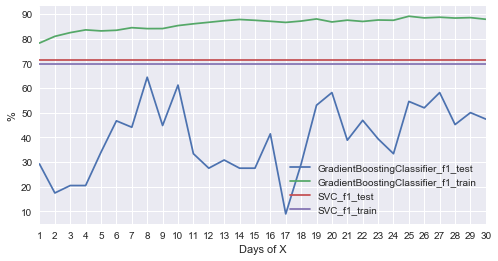

In [29]:
results_best          = score_day(X, y, clfs, size = Page_size/2,
     feature_days_max = 30,
     feature          = X_base)

----
## Improving Results
### Advanced Features
Besides the previous base features, all researched features above are applied here.
The classifier trained with 8-day features has great improvement while too long days with weak correlations cause too much overfitting.
Therefore, the next tuning will use the same 8-day features to tune the hyperparameters to reduce the **overfitting**.

The best classifier is GradientBoostingClassifier with 75.61% f1-score and 8-day features to predict Close_Close_next_up 


,Up_predict,Down_predict
Up_true,31,8
Down_true,12,19


             precision    recall  f1-score   support

         Up       0.72      0.79      0.76        39
       Down       0.70      0.61      0.66        31

avg / total       0.71      0.71      0.71        70



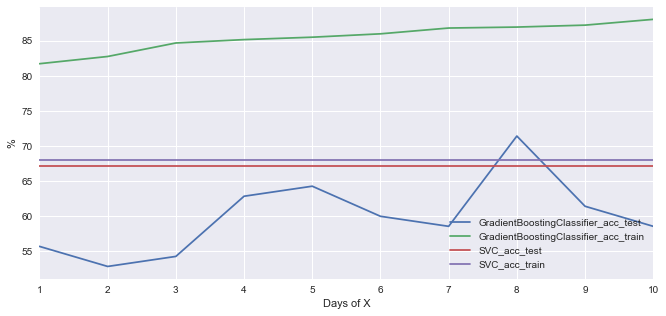

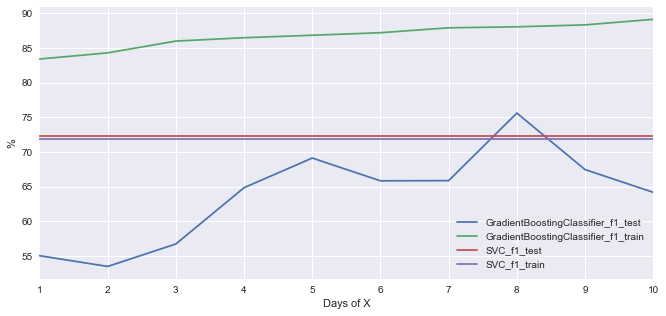

In [30]:
results_best          = score_day(X, y, clfs, size = Page_size*2/3,
     feature_days_max = 10,
     feature          = X_base
                      + X_vec
                      + X_up
                      + X_stat
                                 )

### Feature Importance
The best feature is the vector `Close_Open_next` as expected.
The importances of the [Ensemble Tree Gradient Boosting Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) are also listed by the way for reference.

In [31]:
def        feature_importances(  features, clf):
    df = pd.DataFrame         ({
          'Features'           : features,
                  'Importances':           clf .
           feature_importances_*100})    . sort_values(by =
                  'Importances', ascending = 0). reset_index(drop = 1).rename(index = lambda c: c + 1)
    df [          'Importances'] = df['Importances'].map(percent.format)
    return df

from sklearn.ensemble import GradientBoostingRegressor
def        feature_importances_GBR(X_train, y_train,     random_state = random_state, X_test = None, y_test = None):
    return feature_importances(    X_train.columns,
                               GradientBoostingRegressor(random_state = random_state).
                               fit(X_train, y_train))

def        feature_importances_display(  results, n = 5):
    display(concat([
           feature_importances        (  results['features']  ,
                                         results['clf'     ]) ,
           feature_importances_GBR    (**results['Xy'      ])], ['Classifier', 'Regressor']).head(n = n))

In [32]:
feature_importances_display(results_best)

Classifier                         Regressor            
               Features Importances              Features Importances
1       Close_Open_next      15.74%       Close_Open_next      13.55%
2  Close_Open_next_pre1       3.25%  Close_Open_next_pre1       3.24%
3           Volume_pre5       2.82%           Volume_pre1       2.60%
4           Volume_pre1       2.63%           Volume_pre5       2.54%
5                  RSI6       2.35%              WR6_pre3       2.42%

### Hyperparameters Tuning
Based on the 8-day features, tuning the key hyperparameters of the [Ensemble Tree Gradient Boosting Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) by [Exhaustive Grid Search](http://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search) with [Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) and [TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to overcome the **overfitting**.
Wide-range hyperparameters has been tested: `learning_rate` (0.005~0.2), `n_estimators` (20~110), `max_depth` (2~16), `min_samples_split` (2~15), `min_samples_leaf` (1~8), `max_features` (0.1~None) and `subsample` (0.6~1).
However, the huge combinations need to be partitioned into many [steps](http://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python) to reduce the time complexity. The detail ranges are in the notebook and the sample is demonstrated below.
The overfitting is easy to overcome but, the required [$F_1-score$](http://wikipedia.org/wiki/F1_score) is improved minor and losing a little accuracy.

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline        import Pipeline
# scaler     = MinMaxScaler()

def Grid   (clf, parameters,                     X = X, y = y, feature = X_all,  n_splits = 3, beta = beta , verbose = 1
                                                                      , feature_days = day_range_Max       ,       n = 5
                                                                      ,        label =    label , train_test_split = date_split):
    (X_train, X_test), (y_train, y_test) = Split(X[pre_feature(feature, feature_days)], y[label], train_test_split)
#     print '{}-day {} with:'.format(feature_days, csv(feature))
    display(concat([pd.DataFrame.from_dict(parameters, orient = 'index', dtype = object).T.fillna('').
                    rename(index = lambda c: c + 1)], ['Parameter Grid']))
#     pipe               = Pipeline(steps=[('scaler', scaler), ('clf', clf)])
#     grid               = GridSearchCV(clf, parameters, scoring = 'roc_auc'      (fbeta_score, beta = beta),
    grid               = GridSearchCV(clf, parameters, scoring = make_scorer    (fbeta_score,  beta = beta), verbose = verbose,
                                                       cv      = TimeSeriesSplit(n_splits = n_splits) .split(X_train))
    predict_train      = clf .fit(X_train, y_train)                 . predict(X_train)
    predict_test       = clf                                        . predict(X_test )
    estimator          = grid.fit(X_train, y_train).best_estimator_ 
    predict_train_best =                                 estimator  . predict(X_train)
    predict_test_best  =                                 estimator  . predict(X_test )

    display(concat([pd.DataFrame(OrderedDict([
      ('Train Accuracy'                  ,   [accuracy_score(y_train, predict_train                       )  ,
                                              accuracy_score(y_train, predict_train_best                  )]),
      ( 'Test Accuracy'                  ,   [accuracy_score(y_test , predict_test                        )  ,
                                              accuracy_score(y_test , predict_test_best                   )]),
      ('Train {}'.format(fbeta)          ,   [   fbeta_score(y_train, predict_train     ,      beta = beta)  ,
                                                 fbeta_score(y_train, predict_train_best,      beta = beta)]),
      ( 'Test {}'.format(fbeta)          ,   [   fbeta_score(y_test , predict_test      ,      beta = beta)  ,
                                                 fbeta_score(y_test , predict_test_best ,      beta = beta)]),
                                 ])).applymap(lambda s: '{:.1f}%'.format(100*s)),
         pd.concat([pd.DataFrame( clf. get_params(), index = [0])[parameters.keys()],
                    pd.DataFrame(grid.best_params_ , index = [1])[parameters.keys()]])])
                                             .rename(index = {0:   'Default Model',
                                                              1: 'Optimized Model'}))
    models =                                                 [     'Default' , 'Optimized']
    importances   = feature_importances(X_test.columns, grid.best_estimator_)
    display(concat([feature_importances(X_test.columns,           clf       ),
                            importances]                      , models).head(n = n))
    display(concat([up_down_matrix(y_test, predict_test     ) ,
                    up_down_matrix(y_test, predict_test_best)], models))
    print clf_report              (y_test, predict_test_best)
    return grid,            importances

In [34]:
feature          = results_best['feature']
feature          = X_base + X_vec + X_up + X_stat

parameters = OrderedDict([
    ('learning_rate'    ,
#       list(np.arange    (
# #         0.005           ,
#         0.01            ,
# #         0.011           ,
#         0.05            , # cur
# #         0.1             , # default
# #         0.11            ,
# #         0.2             ,
# #         0.21            ,
# #         0.001
#         0.01
# #         0.05
#                        ))+
    [
#         0.02            ,
        0.03            , # up
        0.04            , # cur
        0.05            , # up
#         0.1             , # default, ini
    ]                  ),
    ('n_estimators'     ,
#       range            (
#        20               ,
# #        50               ,
#       100 +1            , # default
# #       101               ,
#        10
#                        )+
    [
#        30               ,
#        40               ,
       50               , # cur
#        60               ,
      100               , # default, up
#       110               ,
    ]                  ),
    ('max_depth'        ,
#       range            (
#         2               ,
# #         3               , # default
# #         5               ,
# #         8 +1            ,
#        16               ,
#                        )+
    [
        2               , # cur
        3               , # default, up
#         8               , # ini
    ]                  ),
    ('min_samples_split',
#       range            (
# #         2               , # default
#         7               , # 0.5*len(y)
#        15 +1            , #     len(y)
#                        )+
    [
#         2               , # default
        7               , # 0.5*len(y), ini
        8               , # cur
        9               ,
#        15               , #     len(y)
    ]                  ),
    ('min_samples_leaf' ,
#       range            (
#         1               , # default
#         7 +1            , # 0.5*len(y)
#                        )+
    [
        1               , # default, cur
        2               , # up
#         3               , # ini
    ]                  ),
    ('max_features'     ,
#       list(np.arange    (
#         0.1             ,
#         0.5             ,
#         0.1
#                        ))+
    [
#         0.3             ,
        'sqrt'          , # ini, cur
#         0.4             ,
#         None            , # default
    ]                  ),
    ('subsample'        ,
#       list(np.arange    (
#         0.6             ,
#         1               ,
#         0.05
#                        ))+
    [
        0.7             , # low
        0.8             , # ini, cur
        0.9             , # up
#         1               , # default
    ]                  ),
    ]                  )
# parameters       = OrderedDict([(k, [v]) for k, v in GBC.get_params().items() if k in parameters.keys()])
# parameters       = [{'kernel': ['rbf'   ], 'C': [1, 10, 100, 1000], 'gamma': [1e-3, 1e-4]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]                       }]

grid, importances = Grid(
    GradientBoostingClassifier(random_state = random_state, warm_start = True),
#     svc,
    parameters, X, y,
    feature,
    n = 10 ,
    feature_days = results_best['days']
#     feature_days = 8
)

Parameter Grid                                                            \
   learning_rate n_estimators max_depth min_samples_split min_samples_leaf   
1           0.03           50         2                 7                1   
2           0.04          100         3                 8                2   
3           0.05                                        9                    

                          
  max_features subsample  
1         sqrt       0.7  
2                    0.8  
3                    0.9

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:  1.4min finished


,Train Accuracy,Test Accuracy,Train f1,Test f1,learning_rate,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,subsample
Default Model,87.0%,71.4%,88.0%,75.6%,0.10,100,3,2,1,None,1.0
Optimized Model,71.2%,68.6%,75.4%,76.1%,0.04,50,2,8,1,sqrt,0.8


Default                         Optimized            
                Features Importances              Features Importances
1        Close_Open_next      15.74%       Close_Open_next      12.16%
2   Close_Open_next_pre1       3.25%    Close_Open_next_up       9.78%
3            Volume_pre5       2.82%                  RSI6       3.86%
4            Volume_pre1       2.63%   Open_Open_next_pre6       3.06%
5                   RSI6       2.35%             WR10_pre6       2.60%
6    Open_pre_Close_pre1       2.05%             WR10_pre3       2.39%
7              WR10_pre2       2.03%  Close_pre_Close_pre5       2.29%
8    Open_Open_next_pre7       1.83%            Open_Close       1.94%
9               WR6_pre3       1.74%           Volume_pre2       1.93%
10            RSI12_pre7       1.69%             WR10_pre2       1.91%

Default               Optimized             
          Up_predict Down_predict Up_predict Down_predict
Up_true           31            8         35            4
Down_true         12           19         18           13

             precision    recall  f1-score   support

         Up       0.66      0.90      0.76        39
       Down       0.76      0.42      0.54        31

avg / total       0.71      0.69      0.66        70



### Feature Selection
Based on the high feature importances and correlations above, `Volume` (Base Feature), `WR10`, `RSI6` (Statistics Features), Vector and corresponding Up Features are selected to explore huge feature combinations with extended day range for improvement of overfitting and accuracy at the same time.
Finally, the [$F_1-score$](http://wikipedia.org/wiki/F1_score) can be improved to 83.72%.

In [35]:
features         = [
#                     'Open'              ,
#                     'High'              ,
#                     'Low'               ,
#                     'Close'             ,
#                     'Open_next'         ,
                    'Volume'            ,
                    'Open_pre_Close'    ,
                    'Open_pre_Close_up' ,
                    'Close_pre_Close'   ,
                    'Close_pre_Close_up',
                    'Open_Close'        ,
                    'Open_Close_up'     ,
                    'Open_Open_next'    ,
                    'Open_Open_next_up' ,
                    'Close_Open_next'   ,
                    'Close_Open_next_up',
                    'WR10'              ,
#                     'WR6'               ,
#                     'RSI12'             ,
                    'RSI6'              ,
#                     'MACD'              ,
#                     'C2M'               ,
#                     'Boll_u'            ,
#                     'Boll'              ,
#                     'Boll_l'            ,
                   ]
clf              = [
                    GBC, 
#                     GradientBoostingClassifier(random_state = random_state, **grid.best_params_),
                   ]
# display(concat([pd.DataFrame({k: v for k, v in grid.best_params_.items() if k in parameters.keys()},
#                              index = ['best'])], ['params']))
feature_days_max =  14

from tqdm      import tqdm
from itertools import combinations
results_best = {fbeta: 0}
for n in range(6, 1   +                    len(features)   ):
    for feature in tqdm(map(list, combinations(features, n))):
        cur                     = score_day   (output = 0,
            clfs                = clf,
            feature_days_max    =              feature_days_max,
            feature             =              feature)
        if  results_best[fbeta] < cur         [fbeta]:
            results_best        = cur
            print '{:.2f}% {} by {}-day {}'.format(100*cur[fbeta], fbeta, cur['days'], csv(feature))

  0%|                                                                                         | 0/1716 [00:00<?, ?it/s]

59.09% f1 by 4-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Open_Close


  0%|                                                                               | 1/1716 [00:06<3:16:58,  6.89s/it]

65.26% f1 by 1-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Open_Close_up


  0%|                                                                               | 2/1716 [00:12<3:09:40,  6.64s/it]

65.85% f1 by 1-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Open_Open_next


  0%|▏                                                                              | 3/1716 [00:19<3:11:40,  6.71s/it]

68.89% f1 by 1-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Open_Open_next_up


  0%|▏                                                                              | 4/1716 [00:25<3:04:23,  6.46s/it]

75.86% f1 by 8-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Close_Open_next


  2%|█▏                                                                            | 26/1716 [03:00<3:27:14,  7.36s/it]

76.74% f1 by 8-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Open_Open_next_up & Close_Open_next


  2%|█▌                                                                            | 34/1716 [03:56<3:24:58,  7.31s/it]

76.92% f1 by 5-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_Open_next_up & RSI6


  5%|████                                                                          | 90/1716 [10:26<3:08:45,  6.97s/it]

77.65% f1 by 7-day Volume, Open_pre_Close, Open_pre_Close_up, Open_Close_up, Open_Open_next_up & Close_Open_next


  6%|████▎                                                                         | 96/1716 [11:15<3:35:31,  7.98s/it]

79.55% f1 by 8-day Volume, Open_pre_Close, Open_pre_Close_up, Open_Close_up, Close_Open_next & RSI6


 14%|██████████▌                                                                  | 235/1716 [30:01<2:52:33,  6.99s/it]

83.72% f1 by 12-day Volume, Open_pre_Close, Close_pre_Close_up, Open_Close_up, Close_Open_next & WR10


100%|██████████████████| 1/1 [00:14<00:00, 14.02s/it]


### Model Evaluation, Validation, Justification and Visualization
Based on the features above and wide-range hyperparameters tested, the best result tested with the unseen data this year has very near training/testing scores that are quite reasonable, trusted and good than expectation and the [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) benchmark model, although the testing set is a little small and still have chance to overfit.
The model is robust to the incoming data everyday, e.g., the [$F_1-score$](http://wikipedia.org/wiki/F1_score) is improved from 83.72% to 84.09% with the last coming data of 2018-04-17 (comparing the notebooks Stock_Up_Mincent_0414.ipynb and Stock_Up_Mincent_0417.ipynb).
The solution should be enough for the defined problem and conditions (only daily prices and volume features) currently, but for practical applications, the model should be re-trained continuously with the latest incoming data to learn the latest evolution of the market behavior.

The best classifier is GradientBoostingClassifier with 83.72% f1-score and 12-day features to predict Close_Close_next_up 


,Up_predict,Down_predict
Up_true,36,3
Down_true,11,20


             precision    recall  f1-score   support

         Up       0.77      0.92      0.84        39
       Down       0.87      0.65      0.74        31

avg / total       0.81      0.80      0.79        70



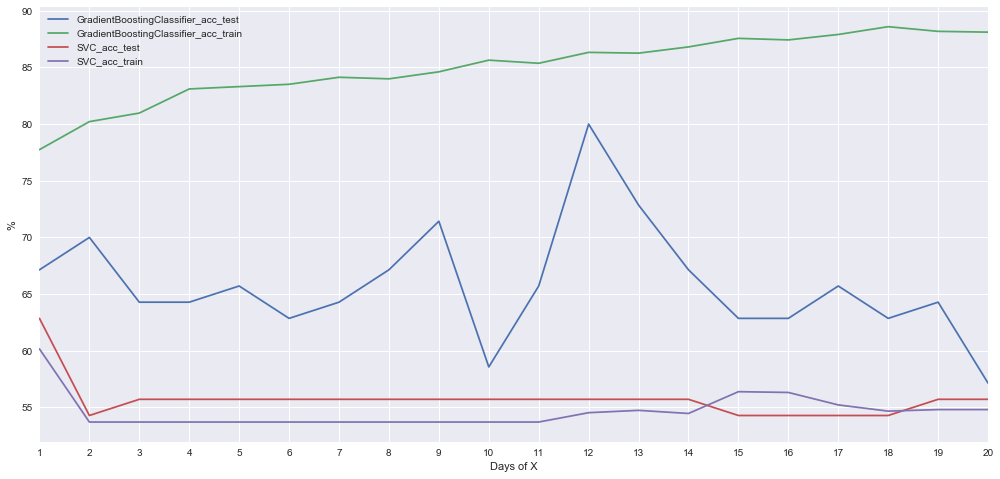

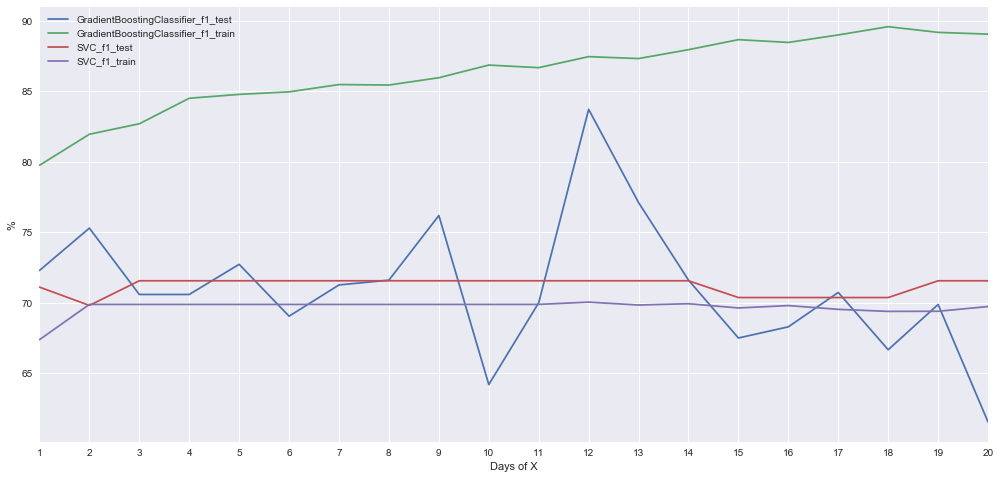

In [36]:
feature              = [
                        'Volume'            ,
                        'Open_pre_Close'    ,
                        'Close_pre_Close_up',
                        'Open_Close_up'     ,
                        'Close_Open_next'   ,
                        'WR10'              ,
                       ]
feature              = results_best['feature']

results_best         = score_day(X, y, clfs,
    feature_days_max = 20,
    feature          =               feature )

### Reflection
#### _Process Summary_
- Data Engineering
  - Data Getting
  - Data Cleaning
- Feature Engineering
  - **Deriving** Statistics, Vector and Corresponding Classification Features and Labels
  - **Feature Selection** by Visualization and Comparison of Data Correlations
  - Log-Transforming the Skewed Continuous Feature
  - Normalizing Numerical Features
  - Feature Preprocessing for Stacking Daily Data of Day Range
  - Splitting Data for Training and Testing
- Model Tuning
  - Initial Model Evaluation
  - Applying Advanced Features
  - Feature Importance Evaluation
  - Hyperparameters Tuning
  - Feature Selection
- Many Iterations for Feature Engineering and Parameters Tuning

Predicting stock price is very interesting but difficult.
Notably, the classification is expected initially to be easier than regression.
However, the long-term trend of prices is easy to follow and regress, but the daily small fluctuation is very hard to predict and classify the price up/down.
A default [Ensemble Tree Gradient Boosting Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) with only the base features (`Open`, `High`, `Low`, `Close` and `Volume`) can easily follow the prices, but the predicted prices cannot provide good up/down predictions.
Predicting the nearer prices, e.g., `Open_next` (`Open` prices of the next day), is better.

Close_next Regression r2-Score:  77.29%
Close_next Regression to Up/Down Classification Accuracy Score:  55.71%
Close_next Regression to Up/Down Classification       F1-Score:  71.56%


,Up_predict,Down_predict
Up_true,39,0
Down_true,31,0


             precision    recall  f1-score   support

         Up       0.56      1.00      0.72        39
       Down       0.00      0.00      0.00        31

avg / total       0.31      0.56      0.40        70



,Close,Close_next,Close_next_Regression (Test),Up_true,Up_predict
2018-04-07,2604.47,2613.16,2608.719748,True,True
2018-04-10,2613.16,2656.87,2617.459317,True,True
2018-04-11,2656.87,2642.19,2659.246514,False,True
2018-04-12,2642.19,2663.99,2644.513344,True,True
2018-04-13,2663.99,2656.30,2666.069816,False,True


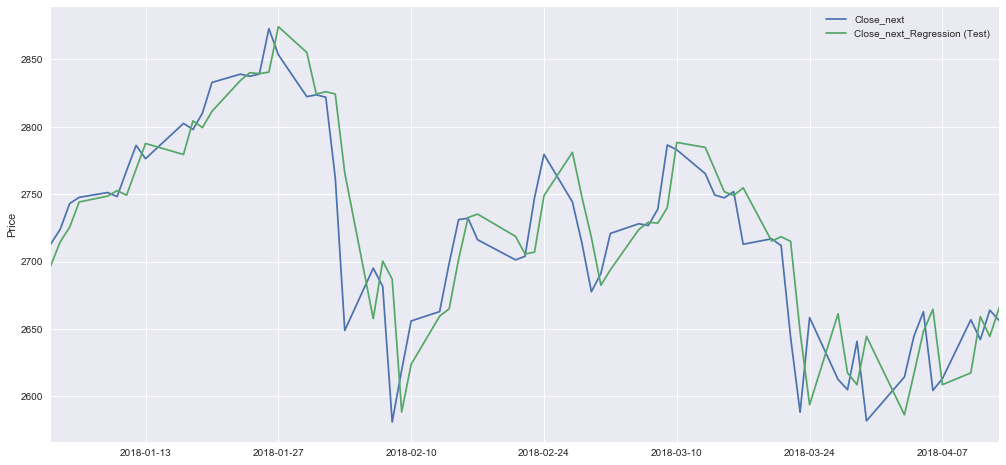

Open_next Regression r2-Score:  97.13%
Open_next Regression to Up/Down Classification Accuracy Score:  78.57%
Open_next Regression to Up/Down Classification       F1-Score:  80.52%


,Up_predict,Down_predict
Up_true,31,8
Down_true,7,24


             precision    recall  f1-score   support

         Up       0.82      0.79      0.81        39
       Down       0.75      0.77      0.76        31

avg / total       0.79      0.79      0.79        70



,Open,Open_next,Open_next_Regression (Test),Up_true,Up_predict
2018-04-07,2645.82,2617.18,2606.071142,False,False
2018-04-10,2617.18,2638.41,2614.287080,True,False
2018-04-11,2638.41,2643.89,2657.792864,True,True
2018-04-12,2643.89,2653.83,2643.203038,True,False
2018-04-13,2653.83,2676.90,2664.924024,True,True


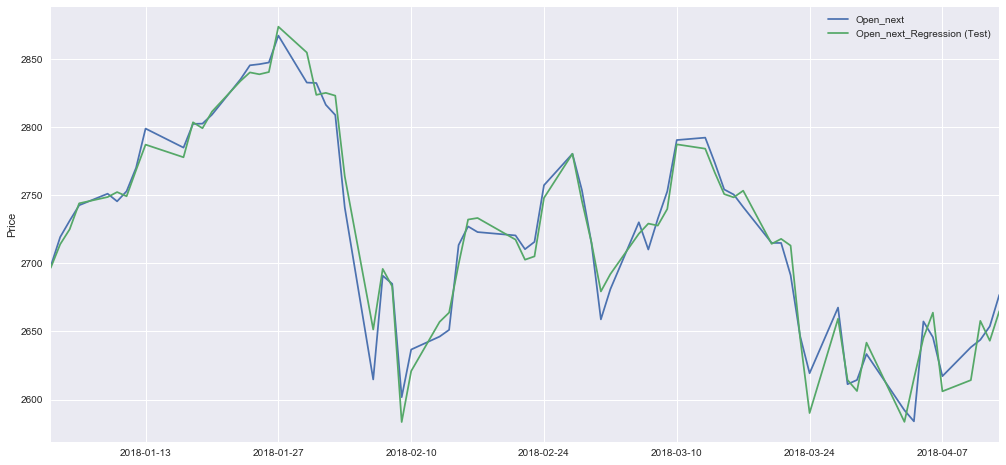

In [38]:
labels          = ['Close_next', 'Open_next']
feature         =   X_base

from sklearn.metrics import           r2_score

data_train,       data_test = Split1(data_log[day_range_Max - 1:], date_split)
for label in   labels:
    y_train_raw = data_train[[label]]
    y_test_raw  = data_test [[label]]
    scaler_y    =     MinMaxScaler().fit            (                                             y_train_raw )
    regressor   = LinearRegression().fit            (X_train[feature], scaler_y.        transform(y_train_raw))
    predict     =       regressor   .       predict (X_test [feature])
    regression  = y_test_raw.copy()
    regression[label +'_Regression (Test)'] =                          scaler_y.inverse_transform(
                                            predict                                                           )
    print           '{} Regression r2-Score: {:6.2f}%'                                 .format   (label, 100*
                                   r2_score(predict                  , scaler_y        .transform(y_test_raw )))
    x           = label.split('_')[0]
    true        =           data_test['{}_{}_up'.format(x, label)]
    predict     =           data_test[                  x        ] <= regression.iloc[:, -1]
    acc, f1     = clf_scores(true,          predict, beta)
    print           '{} Regression to Up/Down Classification Accuracy Score: {:6.2f}%' .format   (label, 100* acc)
    print           '{} Regression to Up/Down Classification       F1-Score: {:6.2f}%' .format   (label, 100*  f1)
    confusion_report(true,                  predict)
    ax = regression.plot( figsize = (Page_size, Page_size/2));
    ax .    set_ylabel  ('Price')
    regression.insert(0, x, data_test[                  x        ])
    regression['Up_true'   ] = true
    regression['Up_predict'] = predict
    display(regression.tail())
    plt.show()

### Improvement
The features importances shows that the model still pays too much attention to the previous days.
The models which consider the critical feature of time sequence, e.g., [Long Short-Term Memory (LSTM)](http://wikipedia.org/wiki/Long_short-term_memory),
[Recurrent Neural Network (RNN)](http://wikipedia.org/wiki/Recurrent_neural_network), and the more advanced
[attention mechanism](http://arxiv.org/abs/1706.03762), should work better.
More important features of the global stock market, currency market, company status and financial related news, etc. and more data, maybe hourly prices, also should be considered.

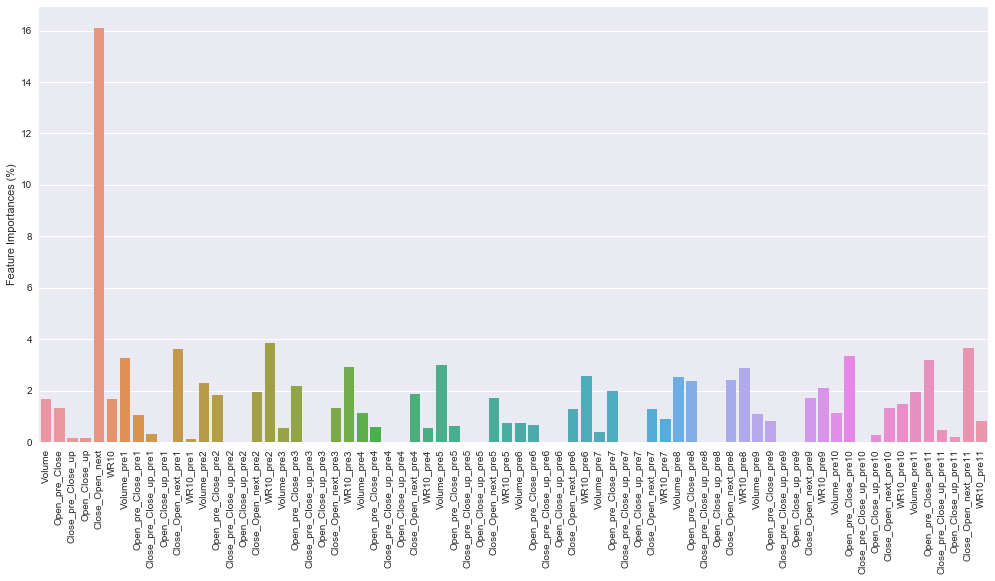

In [37]:
f = sns.barplot(results_best['features'],
                results_best['clf'     ].feature_importances_*100,
                ax  = plt.subplots(figsize = (Page_size, Page_size/2))[1]);
f.set_xticklabels(f.get_xticklabels(), rotation = 90)
f.set_ylabel   (                        'Feature Importances (%)');